This notebook shows the single-Gaussian, double-Gaussian, and kappa fitting of SUMER lines with non-Gaussian wings. 
Links to [Figure 15a](#figure15a), [Figure 15b](#figure15b), [Figure 15c](#figure15c), and [Figure 16](#figure16). 

(The internal hyperlink only works on [nbviewer](https://nbviewer.org). Do not click when viewing the notebook on GitHub.)

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import astropy.constants as const
import pandas as pd
import cmcrameri as cmcm
from matplotlib import rcParams
from matplotlib import ticker
import juanfit
import importlib
importlib.reload(juanfit)
from juanfit import SpectrumFitSingle,gaussian,voigt
import scipy.io
from sumerpy import con_width_funct_4, radiometry
from brokenaxes import brokenaxes
import scipy.special as spec_func
from scipy.integrate import simps

In [2]:
class SpectrumFitCustom(SpectrumFitSingle):
    def get_fit_and_res(self):
        if self.custom_func is not None:
            pass
        else:
            line_wvl_plot = self.line_wvl_fit
            int_total_plot = self.int_total_fit
            fwhm_plot = self.fwhm_fit
            int_cont_plot = self.int_cont_fit
            line_wvl_err_plot = self.line_wvl_err
            int_total_err_plot = self.int_total_err
            fwhm_err_plot = self.fwhm_err
            int_cont_err_plot = self.int_cont_err

        if self.custom_func is not None:
            spec_fit = self.custom_func(self.wvl_plot,*self.custom_fit)
            res_fit = self.data_tofit - self.custom_func(self.wvl_tofit,*self.custom_fit)                
        elif self.same_width is True:
            p_fit = np.concatenate((line_wvl_plot,int_total_plot,fwhm_plot,
                                    int_cont_plot),axis=None)
            spec_fit = self.multi_gaussian_same_width(self.wvl_plot,*p_fit)
            res_fit = self.data_tofit - self.multi_gaussian_same_width(self.wvl_tofit,*p_fit) 
        else:
            p_fit = np.concatenate((line_wvl_plot,int_total_plot,fwhm_plot,
                                    int_cont_plot),axis=None)
            spec_fit = self.multi_gaussian_diff_width(self.wvl_plot,*p_fit) 
            res_fit = self.data_tofit - self.multi_gaussian_diff_width(self.wvl_tofit,*p_fit)  

        return spec_fit, res_fit

    def get_each_profile(self):
        if self.custom_func is not None:
            pass
        else:
            line_wvl_plot = self.line_wvl_fit
            int_total_plot = self.int_total_fit
            fwhm_plot = self.fwhm_fit
            int_cont_plot = self.int_cont_fit
            line_wvl_err_plot = self.line_wvl_err
            int_total_err_plot = self.int_total_err
            fwhm_err_plot = self.fwhm_err
            int_cont_err_plot = self.int_cont_err

        if self.custom_func is None:
            if self.line_number > 1:
                line_profiles = []
                if self.same_width is True:
                    for jj in range(self.line_number):
                        line_profile = gaussian(self.wvl_plot, line_wvl_plot[jj],
                                                int_total_plot[jj], fwhm_plot) \
                                        + int_cont_plot
                    line_profiles.append(line_profile)
                else:
                    for jj in range(self.line_number):
                        line_profile = gaussian(self.wvl_plot, line_wvl_plot[jj],
                                                int_total_plot[jj], fwhm_plot[jj]) \
                                        + int_cont_plot
                        line_profiles.append(line_profile)

        return line_profiles


In [3]:
sumer_img = scipy.io.readsav("../../save/sumer_merg.sav")["int_merg"]

wvl_338 = np.linspace(0,1023,1024)*0.04496629878144223 + 671.7967194748996
sumer_338_window = sumer_img[:,:1024]

wvl_375 = np.linspace(0,1023,1024)*0.044790246422816475 + 745.655738274089
sumer_375_window = sumer_img[:,1024:2048]

wvl_509 = np.linspace(0,1023,1024)*0.04381162280734919 + 1015.1032588901901
sumer_509_window = sumer_img[:,2048:3072]

wvl_607 = np.linspace(0,1023,1024)*0.04316670824233466 + 1209.3346601414057
sumer_607_window = sumer_img[:,3072:]

sumer_ycen = 1119.81
sumer_ycoord = np.linspace(sumer_ycen-299.2/2,sumer_ycen+299.2/2,300) - 5

In [4]:
OVI_1032_slice = (360,420)
wvl_OVI_1032 = wvl_509[OVI_1032_slice[0]:OVI_1032_slice[1]]
radiometry_OVI_1032 = radiometry(1,wvl_OVI_1032,1,np.ones_like(wvl_OVI_1032),bare=False,kbr=True,photons=False,watts=True,det_a=False,
                                det_b=True,joint=False,separate=True)*1.e3
int_OVI_1032 = np.average(sumer_509_window[-30:,OVI_1032_slice[0]:OVI_1032_slice[1]],axis=0)*radiometry_OVI_1032
err_OVI_1032 = np.sqrt(np.sum(300*sumer_509_window[-30:,OVI_1032_slice[0]:OVI_1032_slice[1]],
                        axis=0))/30/300*radiometry_OVI_1032
                    

/Users/yjzhu/Desktop/Solar/MyPy/sumerpy.py:457: UserWarning: No test phase set by default.
  warn("No test phase set by default.")


FWHM after removing instrumental broadening:  [291.20410943]


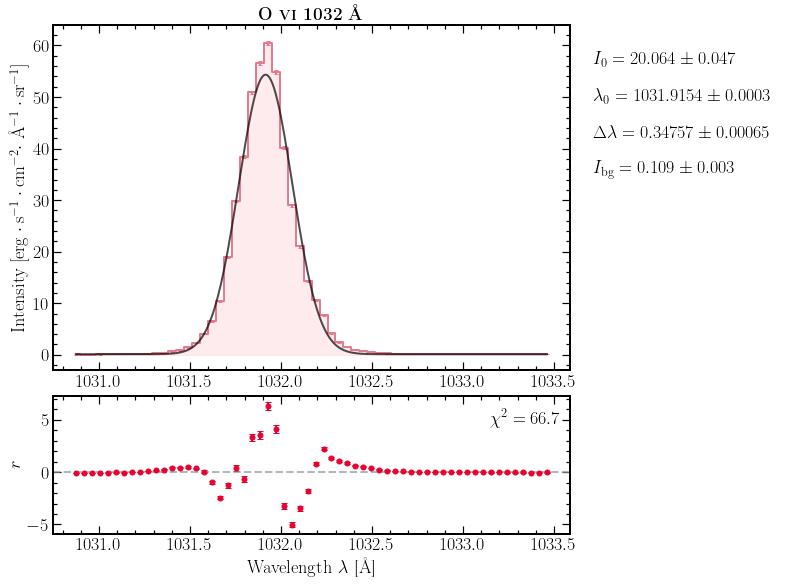

In [6]:
OVI_1032_fit_model = SpectrumFitCustom(data=int_OVI_1032,wvl=wvl_OVI_1032,err=err_OVI_1032,
                                      same_width=True,line_number=1,line_wvl_init=[1032],
                                      int_max_init=[10],fwhm_init=[0.2])
#OVI_1032_fit_model.plot(plot_fit=False,plot_params=False)
#OVI_1032_fit_model.run_lse()
OVI_1032_fit_model.run_lse(absolute_sigma=True)
OVI_1032_fit_model.plot(plot_title=r"\textbf{O \textsc{vi} 1032 \mbox{\AA}}",plot_hmc=False,
                                 xlabel=r"Wavelength $\lambda$ [\mbox{\AA}]",
                               ylabel=r"Intensity $\mathrm{[erg\cdot s^{-1}\cdot cm^{-2}\cdot}$ \mbox{\AA}$\mathrm{^{-1}\cdot sr^{-1}]}$",
                              color_style="Red")
print("FWHM after removing instrumental broadening: ",
con_width_funct_4(1,OVI_1032_fit_model.line_wvl_fit,1,OVI_1032_fit_model.fwhm_fit*1000,DET_B=True))

FWHM after removing instrumental broadening:  [165.93294866 412.52078357]


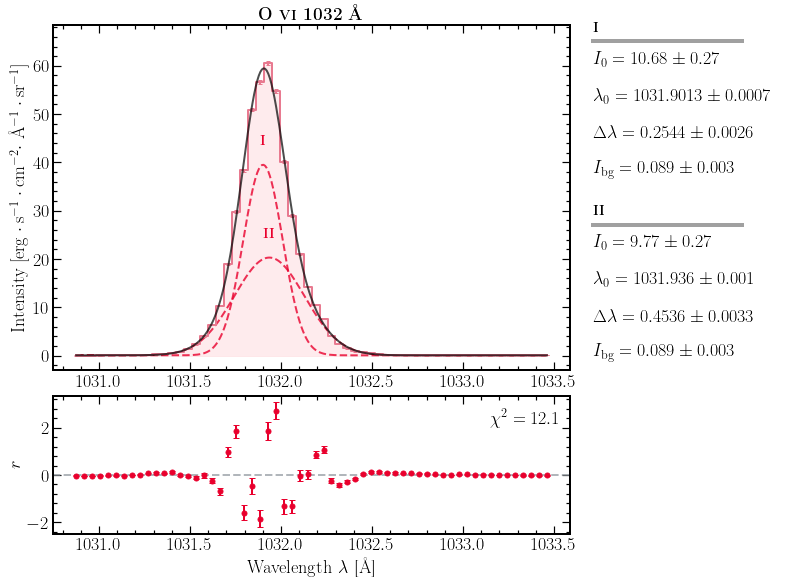

In [7]:
OVI_1032_fit_double_model = SpectrumFitCustom(data=int_OVI_1032,wvl=wvl_OVI_1032,err=err_OVI_1032,
                                      same_width=False,line_number=2,line_wvl_init=[1031.93,1031.93],
                                      int_max_init=[60,5],fwhm_init=[0.3,0.6])
#OVI_1032_fit_model.plot(plot_fit=False,plot_params=False)
OVI_1032_fit_double_model.run_lse(absolute_sigma=True)
#OVI_1032_fit_model.run_HahnMC(n_chain=10000)
OVI_1032_fit_double_model.plot(plot_title=r"\textbf{O \textsc{vi} 1032 \mbox{\AA}}",plot_hmc=False,
                                 xlabel=r"Wavelength $\lambda$ [\mbox{\AA}]",
                               ylabel=r"Intensity $\mathrm{[erg\cdot s^{-1}\cdot cm^{-2}\cdot}$ \mbox{\AA}$\mathrm{^{-1}\cdot sr^{-1}]}$",
                              color_style="Red")
print("FWHM after removing instrumental broadening: ",
con_width_funct_4(1,OVI_1032_fit_double_model.line_wvl_fit,1,OVI_1032_fit_double_model.fwhm_fit*1000,DET_B=True))

In [8]:
print("{:.2f} +/- {:.2f}".format(OVI_1032_fit_double_model.int_total_fit[0],OVI_1032_fit_double_model.int_total_err[0]))
print("{:.2f} +/- {:.2f}".format(OVI_1032_fit_double_model.int_total_fit[1],OVI_1032_fit_double_model.int_total_err[1]))

10.68 +/- 0.27
9.77 +/- 0.27


/anaconda3/lib/python3.7/site-packages/scipy/optimize/minpack.py:834: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)
/Users/yjzhu/Desktop/Solar/MyPy/juanfit.py:477: UserWarning: Use custom function in the fitting. Will not plot fitted parameters.
  warn("Use custom function in the fitting. Will not plot fitted parameters.")


[1.03191522e+03 2.03237448e+01 3.32212523e-01 1.46441799e-02
 1.00000000e-01]


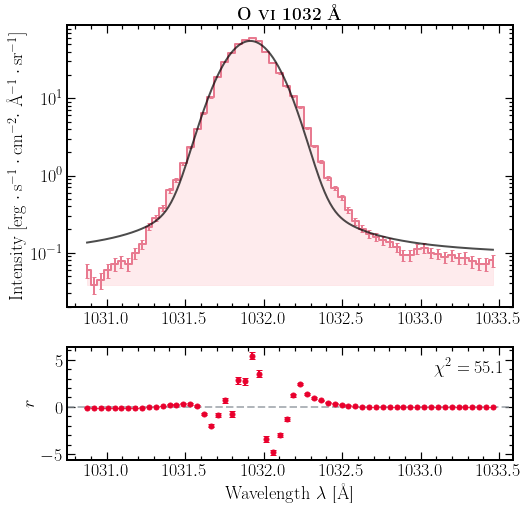

In [9]:
def OVI_1032_voigt_func(wvl,line_wvl,int_total,g_fwhm,l_fwhm,int_cont):
    return voigt(wvl, line_wvl, int_total, g_fwhm, l_fwhm) + 0.089

OVI_1032_fit_voigt_model = SpectrumFitCustom(data=int_OVI_1032,wvl=wvl_OVI_1032,err=err_OVI_1032,
                                      custom_func=OVI_1032_voigt_func,
                                      custom_init=[1031.9,60,0.25,0.005,0.1])
#OVI_1032_fit_model.plot(plot_fit=False,plot_params=False)
OVI_1032_fit_voigt_model.run_lse(absolute_sigma=True)
ax = OVI_1032_fit_voigt_model.plot(plot_title=r"\textbf{O \textsc{vi} 1032 \mbox{\AA}}",plot_hmc=False,
                                 xlabel=r"Wavelength $\lambda$ [\mbox{\AA}]",
                               ylabel=r"Intensity $\mathrm{[erg\cdot s^{-1}\cdot cm^{-2}\cdot}$ \mbox{\AA}$\mathrm{^{-1}\cdot sr^{-1}]}$",
                              color_style="Red")
ax.set_yscale("log")
print(OVI_1032_fit_voigt_model.custom_fit)

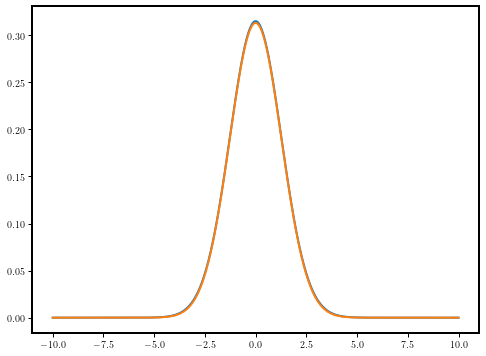

In [10]:
def kappa_func(wvl,line_wvl,int_total,fwhm_k,kappa,int_cont):
    w_k = np.sqrt(1/8/(kappa - 3/2)/(np.power(2,1./kappa) - 1))*fwhm_k
    int_peak = int_total/w_k/np.sqrt(2*np.pi)/np.sqrt(kappa - 3/2)* \
        spec_func.gamma(kappa + 1)/spec_func.gamma(kappa + 1/2)
    line_profile = int_peak*np.power(1 + (wvl - line_wvl)**2/(2*(kappa - 3/2)*w_k**2),-kappa) + int_cont
    return line_profile


fig, ax = plt.subplots(figsize=(8,6))
ax.plot(np.linspace(-10,10,501), kappa_func(np.linspace(-10,10,501),0,1,3,50,0),lw=2)
ax.plot(np.linspace(-10,10,501), gaussian(np.linspace(-10,10,501),0,1,3),lw=2)

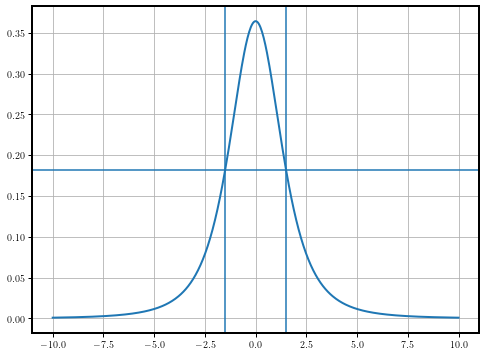

In [11]:
fig, ax = plt.subplots(figsize=(8,6))
ax.plot(np.linspace(-10,10,501), kappa_func(np.linspace(-10,10,501),0,1,3,2,0),lw=2)
ax.axhline(np.max(kappa_func(np.linspace(-10,10,501),0,1,3,2,0))/2)
ax.axvline(-1.5)
ax.axvline(1.5)
ax.grid("on")

In [12]:
OVI_1032_slice_kappa = (360,420)
wvl_OVI_1032_kappa = wvl_509[OVI_1032_slice_kappa[0]:OVI_1032_slice_kappa[1]]
radiometry_OVI_1032_kappa = radiometry(1,wvl_OVI_1032_kappa,1,np.ones_like(wvl_OVI_1032_kappa),bare=False,kbr=True,photons=False,watts=True,det_a=False,
                                det_b=True,joint=False,separate=True)*1.e3
int_OVI_1032_kappa = np.average(sumer_509_window[-30:,OVI_1032_slice_kappa[0]:OVI_1032_slice_kappa[1]],axis=0)*radiometry_OVI_1032_kappa
err_OVI_1032_kappa = np.sqrt(np.sum(300*sumer_509_window[-30:,OVI_1032_slice_kappa[0]:OVI_1032_slice_kappa[1]],
                        axis=0))/30/300*radiometry_OVI_1032_kappa

/Users/yjzhu/Desktop/Solar/MyPy/sumerpy.py:457: UserWarning: No test phase set by default.
  warn("No test phase set by default.")


/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in sqrt
  
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in sqrt
  after removing the cwd from sys.path.
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in power
  """


[1.03191514e+03 1.78248352e+01 3.06584149e-01 3.90040057e+00
 6.72079976e-02]


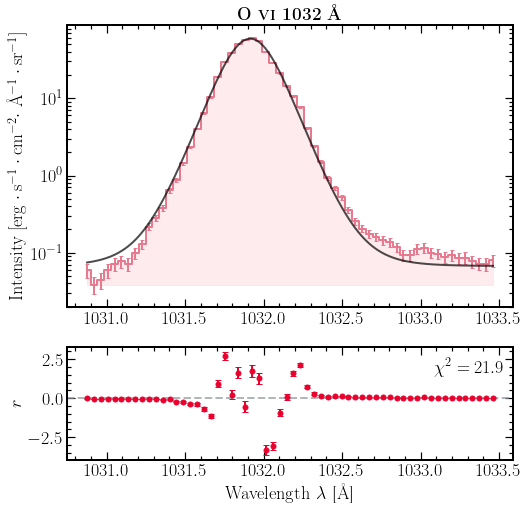

In [13]:
OVI_1032_fit_kappa_model = SpectrumFitCustom(data=int_OVI_1032_kappa,wvl=wvl_OVI_1032_kappa,err=err_OVI_1032_kappa,
                                      custom_func=kappa_func,
                                      custom_init=[1031.9,60,0.2,5,0.1])
#OVI_1032_fit_model.plot(plot_fit=False,plot_params=False)
OVI_1032_fit_kappa_model.run_lse(absolute_sigma=True)
ax = OVI_1032_fit_kappa_model.plot(plot_title=r"\textbf{O \textsc{vi} 1032 \mbox{\AA}}",plot_hmc=False,
                                 xlabel=r"Wavelength $\lambda$ [\mbox{\AA}]",
                               ylabel=r"Intensity $\mathrm{[erg\cdot s^{-1}\cdot cm^{-2}\cdot}$ \mbox{\AA}$\mathrm{^{-1}\cdot sr^{-1}]}$",
                              color_style="Red")
ax.set_yscale("log")
print(OVI_1032_fit_kappa_model.custom_fit)

<AxesSubplot:title={'center':'\\textbf{O \\textsc{vi} 1032 \\mbox{\\AA}}'}, ylabel='Intensity $\\mathrm{[erg\\cdot s^{-1}\\cdot cm^{-2}\\cdot}$ \\mbox{\\AA}$\\mathrm{^{-1}\\cdot sr^{-1}]}$'>

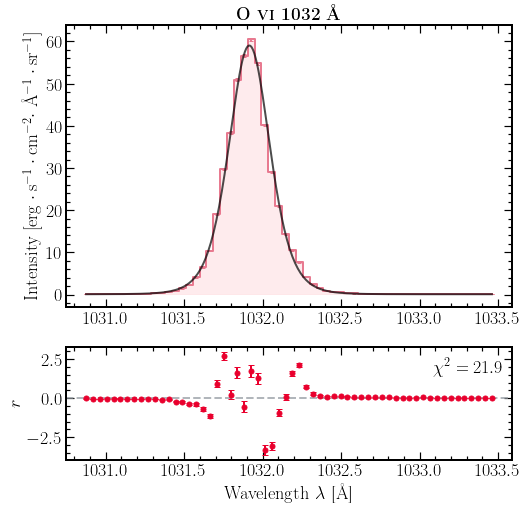

In [14]:
OVI_1032_fit_kappa_model.plot(plot_title=r"\textbf{O \textsc{vi} 1032 \mbox{\AA}}",plot_hmc=False,
                                 xlabel=r"Wavelength $\lambda$ [\mbox{\AA}]",
                               ylabel=r"Intensity $\mathrm{[erg\cdot s^{-1}\cdot cm^{-2}\cdot}$ \mbox{\AA}$\mathrm{^{-1}\cdot sr^{-1}]}$",
                              color_style="Red")

In [15]:
OVI_1037_slice = (470,550)
wvl_OVI_1037 = wvl_509[OVI_1037_slice[0]:OVI_1037_slice[1]]
radiometry_OVI_1037 = radiometry(1,wvl_OVI_1037,1,np.ones_like(wvl_OVI_1037),bare=False,kbr=True,photons=False,watts=True,det_a=False,
                                det_b=True,joint=False,separate=True)*1.e3
int_OVI_1037 = np.average(sumer_509_window[-30:,OVI_1037_slice[0]:OVI_1037_slice[1]],axis=0)*radiometry_OVI_1037
err_OVI_1037 = np.sqrt(np.sum(300*sumer_509_window[-30:,OVI_1037_slice[0]:OVI_1037_slice[1]],
                        axis=0))/30/300*radiometry_OVI_1037

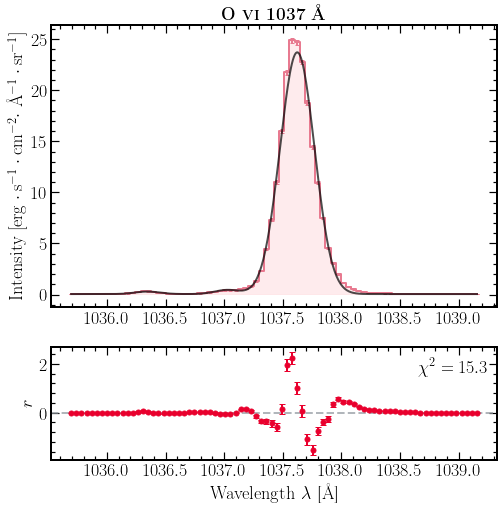

In [16]:
def OVI_1037_CII_1036_func(wvl,int1,int2,int3,wvl1,wvl2,fwhm1,fwhm2,int_cont):
    return gaussian(wvl,wvl1,int1,fwhm1) + gaussian(wvl,wvl1+1037.018-1036.337,int2,fwhm1) + \
      + gaussian(wvl,wvl2,int3,fwhm2) + int_cont

OVI_1037_fit_model = SpectrumFitCustom(data=int_OVI_1037,wvl=wvl_OVI_1037,err=err_OVI_1037,
                                      custom_func=OVI_1037_CII_1036_func,
                                      custom_init=[0.5,1,25,1036.33,1037.62,0.3,0.3,0.07])
#OVI_1037_fit_model.plot(plot_fit=False,plot_params=False)
OVI_1037_fit_model.run_lse(absolute_sigma=True)
# OVI_1037_fit_model.run_HahnMC(n_chain=10000)
ax = OVI_1037_fit_model.plot(plot_title=r"\textbf{O \textsc{vi} 1037 \mbox{\AA}}",plot_hmc=False,
                                 xlabel=r"Wavelength $\lambda$ [\mbox{\AA}]",
                               ylabel=r"Intensity $\mathrm{[erg\cdot s^{-1}\cdot cm^{-2}\cdot}$ \mbox{\AA}$\mathrm{^{-1}\cdot sr^{-1}]}$",
                              color_style="Red")

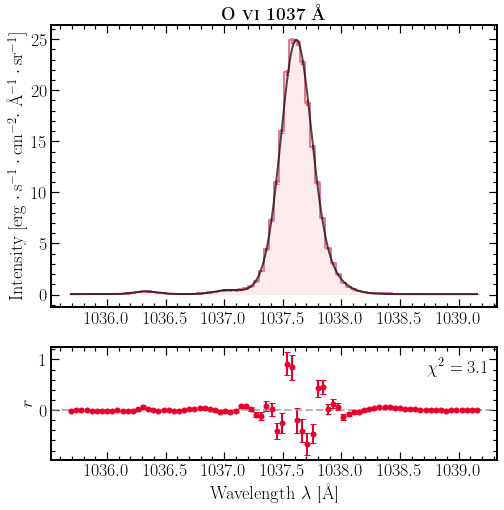

In [17]:
def OVI_1037_CII_1036_double_func(wvl,int1,int2,int3,int4,wvl1,wvl2,wvl3,fwhm1,fwhm2,fwhm3,int_cont):
    return gaussian(wvl,wvl1,int1,fwhm1) + gaussian(wvl,wvl1+1037.018-1036.337,int2,fwhm1) + \
      + gaussian(wvl,wvl2,int3,fwhm2) + gaussian(wvl,wvl3,int4,fwhm3) + int_cont

OVI_1037_fit_double_model = SpectrumFitCustom(data=int_OVI_1037,wvl=wvl_OVI_1037,err=err_OVI_1037,
                                      custom_func=OVI_1037_CII_1036_double_func,
                                      custom_init=[0.5,1,25,2,1036.33,1037.62,1037.64,0.3,0.3,0.6,0.07])
#OVI_1037_fit_model.plot(plot_fit=False,plot_params=False)
OVI_1037_fit_double_model.run_lse(absolute_sigma=True)
ax = OVI_1037_fit_double_model.plot(plot_title=r"\textbf{O \textsc{vi} 1037 \mbox{\AA}}",plot_hmc=False,
                                 xlabel=r"Wavelength $\lambda$ [\mbox{\AA}]",
                               ylabel=r"Intensity $\mathrm{[erg\cdot s^{-1}\cdot cm^{-2}\cdot}$ \mbox{\AA}$\mathrm{^{-1}\cdot sr^{-1}]}$",
                              color_style="Red")

[6.67178528e-02 6.45756799e-02 7.75612499e+00 1.03632315e+03
 1.03762204e+03 2.20226116e-01 3.10518979e-01 4.07375752e+00
 4.37870086e-02]


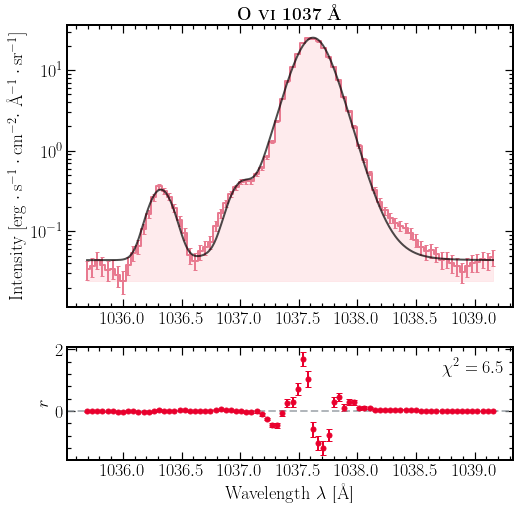

In [18]:
def OVI_1037_CII_1036_kappa_func(wvl,int1,int2,int3,wvl1,wvl2,fwhm1,fwhm2,kappa,int_cont):
    return gaussian(wvl,wvl1,int1,fwhm1) + gaussian(wvl,wvl1+1037.018-1036.337,int2,fwhm1) + \
            kappa_func(wvl,wvl2,int3,fwhm2,kappa,0) + int_cont

OVI_1037_fit_kappa_model = SpectrumFitCustom(data=int_OVI_1037,wvl=wvl_OVI_1037,err=err_OVI_1037,
                                      custom_func=OVI_1037_CII_1036_kappa_func,
                                      custom_init=[0.5,1,25,1036.33,1037.62,0.3,0.3,3,0.07])
#OVI_1037_fit_model.plot(plot_fit=False,plot_params=False)
OVI_1037_fit_kappa_model.run_lse(absolute_sigma=True)
ax = OVI_1037_fit_kappa_model.plot(plot_title=r"\textbf{O \textsc{vi} 1037 \mbox{\AA}}",plot_hmc=False,
                                 xlabel=r"Wavelength $\lambda$ [\mbox{\AA}]",
                               ylabel=r"Intensity $\mathrm{[erg\cdot s^{-1}\cdot cm^{-2}\cdot}$ \mbox{\AA}$\mathrm{^{-1}\cdot sr^{-1}]}$",
                              color_style="Red")
ax.set_yscale("log")
print(OVI_1037_fit_kappa_model.custom_fit)

### Figure 15a
<a id='figure15a'></a>

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:189: UserWarning: FixedFormatter should only be used together with FixedLocator
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:190: UserWarning: FixedFormatter should only be used together with FixedLocator


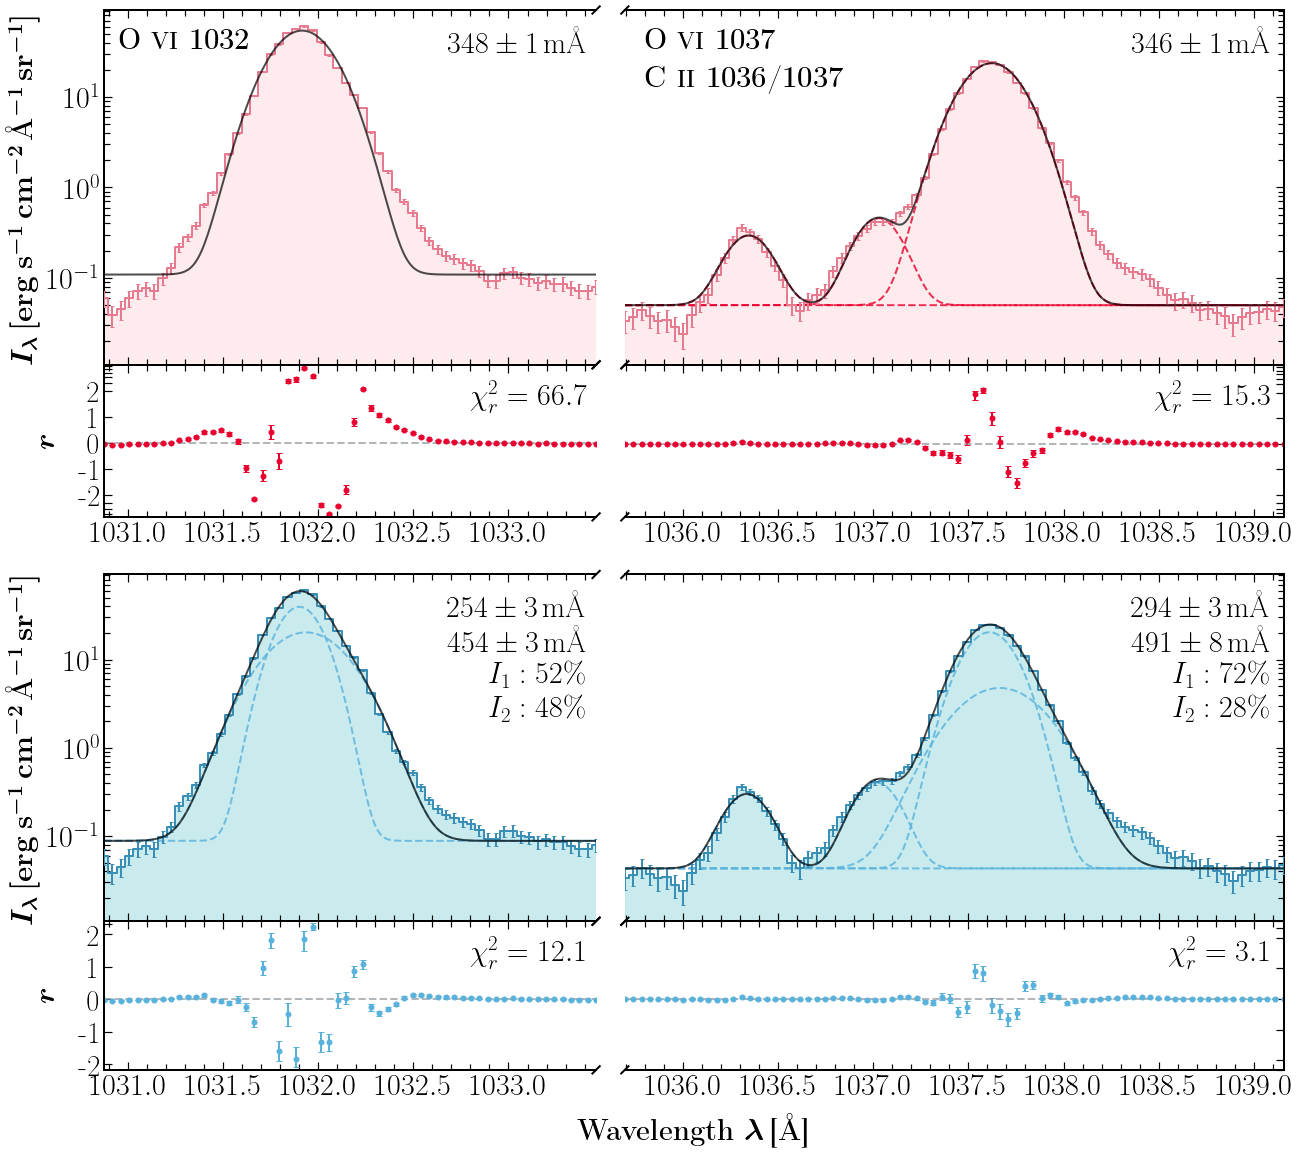

In [19]:
colors_red = ["#E87A90","#FEDFE1","black","#E9002D","#DBD0D0"]
colors_blue = ["#3A8FB7","#A5DEE4","black","#58B2DC","#DBD0D0"]

fontsize=30
labelsize=30

fig = plt.figure(figsize=(18,16),constrained_layout=False)
gs_left = 0.08
gs_right = 0.99
gs1_top = 0.99
gs1_bottom = 0.55
gs2_top = 0.50
gs2_bottom = 0.07
gs1 = fig.add_gridspec(nrows=10, ncols=1, left=gs_left, right=gs_right,bottom=gs1_bottom,top=gs1_top,
                    hspace=0.)
gs2 = fig.add_gridspec(nrows=10, ncols=1, left=gs_left, right=gs_right,bottom=gs2_bottom,top=gs2_top,
                    hspace=0.)

bax1_res = brokenaxes(xlims=((wvl_OVI_1032[0], wvl_OVI_1032[-1]), (wvl_OVI_1037[0], wvl_OVI_1037[-1])),
                     subplot_spec=gs1[7:, :],despine=False,wspace=0.05,d=0.004) 
bax1_fit = brokenaxes(xlims=((wvl_OVI_1032[0], wvl_OVI_1032[-1]), (wvl_OVI_1037[0], wvl_OVI_1037[-1])),
                     subplot_spec=gs1[:7, :],despine=False,wspace=0.05,d=0.004) 

bax2_res = brokenaxes(xlims=((wvl_OVI_1032[0], wvl_OVI_1032[-1]), (wvl_OVI_1037[0], wvl_OVI_1037[-1])),
                     subplot_spec=gs2[7:, :],despine=False,wspace=0.05,d=0.004) 
bax2_fit = brokenaxes(xlims=((wvl_OVI_1032[0], wvl_OVI_1032[-1]), (wvl_OVI_1037[0], wvl_OVI_1037[-1])),
                     subplot_spec=gs2[:7, :],despine=False,wspace=0.05,d=0.004) 

ln1 = bax1_fit.errorbar(OVI_1032_fit_model.wvl,OVI_1032_fit_model.data,yerr = OVI_1032_fit_model.err,
                            ds='steps-mid',color=colors_red[0],capsize=2,label = r"$I_{\rm obs}$",lw=2,zorder=15)

ln2 = bax1_fit.errorbar(OVI_1037_fit_model.wvl,OVI_1037_fit_model.data,yerr = OVI_1037_fit_model.err,
                            ds='steps-mid',color=colors_red[0],capsize=2,label = r"$I_{\rm obs}$",lw=2,zorder=15)

bax1_fit.fill_between(OVI_1032_fit_model.wvl,bax1_fit.axs[0].get_ylim()[0],
                        OVI_1032_fit_model.data,step='mid',color=colors_red[1],alpha=0.6)
bax1_fit.fill_between(OVI_1037_fit_model.wvl,bax1_fit.axs[0].get_ylim()[0],
                        OVI_1037_fit_model.data,step='mid',color=colors_red[1],alpha=0.6)

OVI_1032_single_fit, OVI_1032_single_res = OVI_1032_fit_model.get_fit_and_res()
OVI_1037_single_fit, OVI_1037_single_res = OVI_1037_fit_model.get_fit_and_res()

ln1_fit = bax1_fit.plot(OVI_1032_fit_model.wvl_plot,OVI_1032_single_fit,color=colors_red[2],ls="-",label = r"$I_{\rm fit}$",lw=2,
                            zorder=16,alpha=0.7)

ln2_fit = bax1_fit.plot(OVI_1037_fit_model.wvl_plot,OVI_1037_single_fit,color=colors_red[2],ls="-",label = r"$I_{\rm fit}$",lw=2,
                            zorder=16,alpha=0.7)

bax1_fit.plot(OVI_1037_fit_model.wvl_plot,gaussian(OVI_1037_fit_model.wvl_plot,OVI_1037_fit_model.custom_fit[3],
        OVI_1037_fit_model.custom_fit[0],OVI_1037_fit_model.custom_fit[5])+OVI_1037_fit_model.custom_fit[-1],
        lw=2,alpha=0.8,ls="--",color="#E9002D")
bax1_fit.plot(OVI_1037_fit_model.wvl_plot,gaussian(OVI_1037_fit_model.wvl_plot,OVI_1037_fit_model.custom_fit[3]+1037.018-1036.337,
        OVI_1037_fit_model.custom_fit[1],OVI_1037_fit_model.custom_fit[5])+OVI_1037_fit_model.custom_fit[-1],
        lw=2,alpha=0.8,ls="--",color="#E9002D")
bax1_fit.plot(OVI_1037_fit_model.wvl_plot,gaussian(OVI_1037_fit_model.wvl_plot,OVI_1037_fit_model.custom_fit[4],
        OVI_1037_fit_model.custom_fit[2],OVI_1037_fit_model.custom_fit[6])+OVI_1037_fit_model.custom_fit[-1],
        lw=2,alpha=0.8,ls="--",color="#E9002D")

bax1_fit.axs[0].text(0.03,0.95,r"\textbf{O \textsc{vi} 1032}",fontsize=fontsize,ha="left",va="top",
                        transform=bax1_fit.axs[0].transAxes)  
bax1_fit.axs[0].text(0.98,0.95,
r"${:.0f}\pm{:.0f}\,\si{{m\angstrom}}$".format(OVI_1032_fit_model.fwhm_fit*1e3,OVI_1032_fit_model.fwhm_err*1e3),
ha="right",va="top",fontsize=fontsize,transform=bax1_fit.axs[0].transAxes)
bax1_fit.axs[1].text(0.98,0.95,
r"${:.0f}\pm{:.0f}\,\si{{m\angstrom}}$".format(OVI_1037_fit_model.custom_fit[6]*1e3,OVI_1037_fit_model.custom_err[6]*1e3),
ha="right",va="top",fontsize=fontsize,transform=bax1_fit.axs[1].transAxes)
bax1_fit.axs[1].text(0.03,0.85,r"\textbf{C \textsc{ii} 1036/1037}",fontsize=fontsize,ha="left",va="top",
                        transform=bax1_fit.axs[1].transAxes)       
bax1_fit.axs[1].text(0.03,0.95,r"\textbf{O \textsc{vi} 1037}",fontsize=fontsize,ha="left",va="top",
                        transform=bax1_fit.axs[1].transAxes)  



bax1_res.errorbar(OVI_1032_fit_model.wvl_tofit,OVI_1032_single_res,OVI_1032_fit_model.err_tofit,ds='steps-mid',color=colors_red[3],capsize=3,
                lw=2,ls="none",marker="o",markersize=5)
OVI_1032_single_chi2 = np.sum((OVI_1032_single_res/OVI_1032_fit_model.err_tofit)**2)/OVI_1032_fit_model.dof
bax1_res.axs[0].text(0.98,0.9,r"$\chi_r^2 = {:.1f}$".format(OVI_1032_single_chi2),fontsize=fontsize,
            ha="right",va="top",transform=bax1_res.axs[0].transAxes)


bax1_res.errorbar(OVI_1037_fit_model.wvl_tofit,OVI_1037_single_res,OVI_1037_fit_model.err_tofit,ds='steps-mid',color=colors_red[3],capsize=3,
                lw=2,ls="none",marker="o",markersize=5)
OVI_1037_single_chi2 = np.sum((OVI_1037_single_res/OVI_1037_fit_model.err_tofit)**2)/OVI_1037_fit_model.dof
bax1_res.axs[1].text(0.98,0.9,r"$\chi_r^2 = {:.1f}$".format(OVI_1037_single_chi2),fontsize=fontsize,
            ha="right",va="top",transform=bax1_res.axs[1].transAxes)

bax1_res.axhline(0,ls="--",lw=2,color="#91989F",alpha=0.7) 

ln3 = bax2_fit.errorbar(OVI_1032_fit_model.wvl,OVI_1032_fit_model.data,yerr = OVI_1032_fit_model.err,
                            ds='steps-mid',color=colors_blue[0],capsize=2,label = r"$I_{\rm obs}$",lw=2,zorder=15)

ln4 = bax2_fit.errorbar(OVI_1037_fit_model.wvl,OVI_1037_fit_model.data,yerr = OVI_1037_fit_model.err,
                            ds='steps-mid',color=colors_blue[0],capsize=2,label = r"$I_{\rm obs}$",lw=2,zorder=15)

bax2_fit.fill_between(OVI_1032_fit_model.wvl,bax1_fit.axs[0].get_ylim()[0],
                        OVI_1032_fit_model.data,step='mid',color=colors_blue[1],alpha=0.6)
bax2_fit.fill_between(OVI_1037_fit_model.wvl,bax1_fit.axs[0].get_ylim()[0],
                        OVI_1037_fit_model.data,step='mid',color=colors_blue[1],alpha=0.6)

OVI_1032_double_fit, OVI_1032_double_res = OVI_1032_fit_double_model.get_fit_and_res()
OVI_1037_double_fit, OVI_1037_double_res = OVI_1037_fit_double_model.get_fit_and_res()
OVI_1032_double_line_profiles = OVI_1032_fit_double_model.get_each_profile()


ln3_fit = bax2_fit.plot(OVI_1032_fit_double_model.wvl_plot,OVI_1032_double_fit,color=colors_blue[2],ls="-",label = r"$I_{\rm fit}$",lw=2,
                            zorder=16,alpha=0.7)

ln4_fit = bax2_fit.plot(OVI_1037_fit_double_model.wvl_plot,OVI_1037_double_fit,color=colors_blue[2],ls="-",label = r"$I_{\rm fit}$",lw=2,
                            zorder=16,alpha=0.7)

for OVI_1032_double_line_profile_ in OVI_1032_double_line_profiles:
    bax2_fit.plot(OVI_1032_fit_double_model.wvl_plot,OVI_1032_double_line_profile_,lw=2,alpha=0.8,ls="--",color="#58B2DC")

bax2_fit.plot(OVI_1037_fit_double_model.wvl_plot,gaussian(OVI_1037_fit_double_model.wvl_plot,OVI_1037_fit_double_model.custom_fit[4],
        OVI_1037_fit_double_model.custom_fit[0],OVI_1037_fit_double_model.custom_fit[7])+OVI_1037_fit_double_model.custom_fit[-1],
        lw=2,alpha=0.8,ls="--",color="#58B2DC")
bax2_fit.plot(OVI_1037_fit_double_model.wvl_plot,gaussian(OVI_1037_fit_double_model.wvl_plot,OVI_1037_fit_double_model.custom_fit[4]+1037.018-1036.337,
        OVI_1037_fit_double_model.custom_fit[1],OVI_1037_fit_double_model.custom_fit[7])+OVI_1037_fit_double_model.custom_fit[-1],
        lw=2,alpha=0.8,ls="--",color="#58B2DC")
bax2_fit.plot(OVI_1037_fit_double_model.wvl_plot,gaussian(OVI_1037_fit_double_model.wvl_plot,OVI_1037_fit_double_model.custom_fit[5],
        OVI_1037_fit_double_model.custom_fit[2],OVI_1037_fit_double_model.custom_fit[8])+OVI_1037_fit_double_model.custom_fit[-1],
        lw=2,alpha=0.8,ls="--",color="#58B2DC")
bax2_fit.plot(OVI_1037_fit_double_model.wvl_plot,gaussian(OVI_1037_fit_double_model.wvl_plot,OVI_1037_fit_double_model.custom_fit[6],
        OVI_1037_fit_double_model.custom_fit[3],OVI_1037_fit_double_model.custom_fit[9])+OVI_1037_fit_double_model.custom_fit[-1],
        lw=2,alpha=0.8,ls="--",color="#58B2DC")
        

bax2_fit.axs[0].text(0.98,0.95,
r"${:.0f}\pm{:.0f}\,\si{{m\angstrom}}$".format(OVI_1032_fit_double_model.fwhm_fit[0]*1e3,OVI_1032_fit_double_model.fwhm_err[0]*1e3),
ha="right",va="top",fontsize=fontsize,transform=bax2_fit.axs[0].transAxes)

bax2_fit.axs[0].text(0.98,0.85,
r"${:.0f}\pm{:.0f}\,\si{{m\angstrom}}$".format(OVI_1032_fit_double_model.fwhm_fit[1]*1e3,OVI_1032_fit_double_model.fwhm_err[1]*1e3),
ha="right",va="top",fontsize=fontsize,transform=bax2_fit.axs[0].transAxes)

bax2_fit.axs[0].text(0.98,0.75,
r"$I_1 : {:.0f}\%$".format(OVI_1032_fit_double_model.int_total_fit[0]/np.sum(OVI_1032_fit_double_model.int_total_fit)*100),
ha="right",va="top",fontsize=fontsize,transform=bax2_fit.axs[0].transAxes)

bax2_fit.axs[0].text(0.98,0.65,
r"$I_2 : {:.0f}\%$".format(OVI_1032_fit_double_model.int_total_fit[1]/np.sum(OVI_1032_fit_double_model.int_total_fit)*100),
ha="right",va="top",fontsize=fontsize,transform=bax2_fit.axs[0].transAxes)


bax2_fit.axs[1].text(0.98,0.95,
r"${:.0f}\pm{:.0f}\,\si{{m\angstrom}}$".format(OVI_1037_fit_double_model.custom_fit[8]*1e3,OVI_1037_fit_double_model.custom_err[8]*1e3),
ha="right",va="top",fontsize=fontsize,transform=bax2_fit.axs[1].transAxes)

bax2_fit.axs[1].text(0.98,0.85,
r"${:.0f}\pm{:.0f}\,\si{{m\angstrom}}$".format(OVI_1037_fit_double_model.custom_fit[9]*1e3,OVI_1037_fit_double_model.custom_err[9]*1e3),
ha="right",va="top",fontsize=fontsize,transform=bax2_fit.axs[1].transAxes)

bax2_fit.axs[1].text(0.98,0.75,
r"$I_1 : {:.0f}\%$".format(OVI_1037_fit_double_model.custom_fit[2]/np.sum(OVI_1037_fit_double_model.custom_fit[2:4])*100),
ha="right",va="top",fontsize=fontsize,transform=bax2_fit.axs[1].transAxes)

bax2_fit.axs[1].text(0.98,0.65,
r"$I_2 : {:.0f}\%$".format(OVI_1037_fit_double_model.custom_fit[3]/np.sum(OVI_1037_fit_double_model.custom_fit[2:4])*100),
ha="right",va="top",fontsize=fontsize,transform=bax2_fit.axs[1].transAxes)

bax2_res.errorbar(OVI_1032_fit_double_model.wvl_tofit,OVI_1032_double_res,OVI_1032_fit_double_model.err_tofit,ds='steps-mid',color=colors_blue[3],capsize=3,
                lw=2,ls="none",marker="o",markersize=5)
OVI_1032_double_chi2 = np.sum((OVI_1032_double_res/OVI_1032_fit_double_model.err_tofit)**2)/OVI_1032_fit_double_model.dof
bax2_res.axs[0].text(0.98,0.9,r"$\chi_r^2 = {:.1f}$".format(OVI_1032_double_chi2),fontsize=fontsize,
            ha="right",va="top",transform=bax2_res.axs[0].transAxes)

bax2_res.errorbar(OVI_1037_fit_double_model.wvl_tofit,OVI_1037_double_res,OVI_1037_fit_double_model.err_tofit,ds='steps-mid',color=colors_blue[3],capsize=3,
                lw=2,ls="none",marker="o",markersize=5)
OVI_1037_double_chi2 = np.sum((OVI_1037_double_res/OVI_1037_fit_double_model.err_tofit)**2)/OVI_1037_fit_double_model.dof
bax2_res.axs[1].text(0.98,0.9,r"$\chi_r^2 = {:.1f}$".format(OVI_1037_double_chi2),fontsize=fontsize,
            ha="right",va="top",transform=bax2_res.axs[1].transAxes)

bax2_res.axhline(0,ls="--",lw=2,color="#91989F",alpha=0.7) 


bax2_res.set_xlabel(r"\textbf{Wavelength} $\boldsymbol{\lambda\,}$\textbf{[\mbox{\AA}]}",fontsize=fontsize,labelpad=40)
for bax_res_ in (bax1_res, bax2_res):
    bax_res_.set_yscale("symlog")
    bax_res_.set_ylabel(r"$\boldsymbol{r}$",fontsize=fontsize,labelpad=40)
    bax_res_.axs[1].yaxis.set_tick_params(labelleft=False,left=False,labelright=False,right=True,which="both")
    bax_res_.axs[0].yaxis.set_major_formatter(ticker.ScalarFormatter())
    bax_res_.axs[1].set_yticks(bax_res_.axs[0].get_yticks())
    for ax_ in bax_res_.axs:
        ax_.tick_params(labeltop=False,top=True,bottom=True,direction="in",which="both",
                        labelsize=labelsize) 
        ax_.tick_params(which="major",length=8,width=1.2)
        ax_.tick_params(which="minor",length=6,width=1.2)
        ax_.xaxis.set_minor_locator(ticker.AutoMinorLocator(5))
bax1_res.axs[0].set_yticklabels(['','','','','-2','-1','0','1','2','','',''])
bax2_res.axs[0].set_yticklabels(['','-2','-1','0','1','2',''])
for bax_fit_ in (bax1_fit, bax2_fit):
    bax_fit_.set_ylabel(r"$\boldsymbol{I_\lambda\,\mathrm{[erg\,s^{-1}\,cm^{-2}}}$\,\textbf{\mbox{\AA}}$\boldsymbol{\mathrm{^{-1}\,sr^{-1}}]}$",
                    fontsize=fontsize,labelpad=60)
    bax_fit_.set_yscale("log")
    bax_fit_.axs[1].yaxis.set_tick_params(labelleft=False,left=False,labelright=False,right=True,which="both")
    for ax_ in bax_fit_.axs:
        ax_.tick_params(labeltop=False,top=True,bottom=True,labelbottom=False,direction="in",
                        which="both",labelsize=labelsize)  
        ax_.tick_params(which="major",length=8,width=1.2)
        ax_.tick_params(which="minor",length=6,width=1.2)
        ax_.xaxis.set_minor_locator(ticker.AutoMinorLocator(5))


plt.savefig("../../figs/ms/OVI_doubleGauss.pdf",format="pdf",dpi=300)
# bax1_fit.axs[1].spines['right'].set_visible(True)
# bax1_fit.axs[1].spines['top'].set_visible(True)


In [20]:
NeVIII_770_slice = (540,585)
wvl_NeVIII_770 = wvl_375[NeVIII_770_slice[0]:NeVIII_770_slice[1]]
radiometry_NeVIII_770 = radiometry(1,wvl_NeVIII_770,1,np.ones_like(wvl_NeVIII_770),bare=False,kbr=True,photons=False,watts=True,det_a=False,
                                det_b=True,joint=False,separate=True)*1.e3
int_NeVIII_770 = np.average(sumer_375_window[-30:,NeVIII_770_slice[0]:NeVIII_770_slice[1]],axis=0)*radiometry_NeVIII_770
err_NeVIII_770 = np.sqrt(np.sum(300*sumer_375_window[-30:,NeVIII_770_slice[0]:NeVIII_770_slice[1]],
                        axis=0))/30/300*radiometry_NeVIII_770

/Users/yjzhu/Desktop/Solar/MyPy/sumerpy.py:457: UserWarning: No test phase set by default.
  warn("No test phase set by default.")


FWHM after removing instrumental broadening:  [233.45412011]


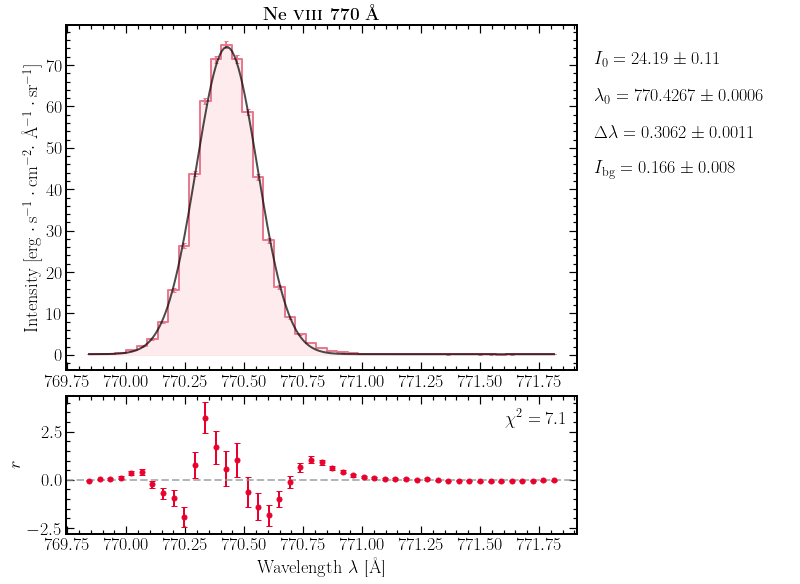

In [21]:
NeVIII_770_fit_model = SpectrumFitCustom(data=int_NeVIII_770,wvl=wvl_NeVIII_770,err=err_NeVIII_770,
                                      same_width=True,line_number=1,line_wvl_init=[770.4],
                                      int_max_init=[70],fwhm_init=[0.3])
#NeVIII_770_fit_model.plot(plot_fit=False,plot_params=False)
NeVIII_770_fit_model.run_lse(absolute_sigma=True)
NeVIII_770_fit_model.plot(plot_title=r"\textbf{Ne \textsc{viii} 770 \mbox{\AA}}",plot_hmc=False,
                                 xlabel=r"Wavelength $\lambda$ [\mbox{\AA}]",
                               ylabel=r"Intensity $\mathrm{[erg\cdot s^{-1}\cdot cm^{-2}\cdot}$ \mbox{\AA}$\mathrm{^{-1}\cdot sr^{-1}]}$")
print("FWHM after removing instrumental broadening: ",
con_width_funct_4(1,NeVIII_770_fit_model.line_wvl_fit,1,NeVIII_770_fit_model.fwhm_fit*1000,DET_B=True))

FWHM after removing instrumental broadening:  [200.69885631 420.17741958]


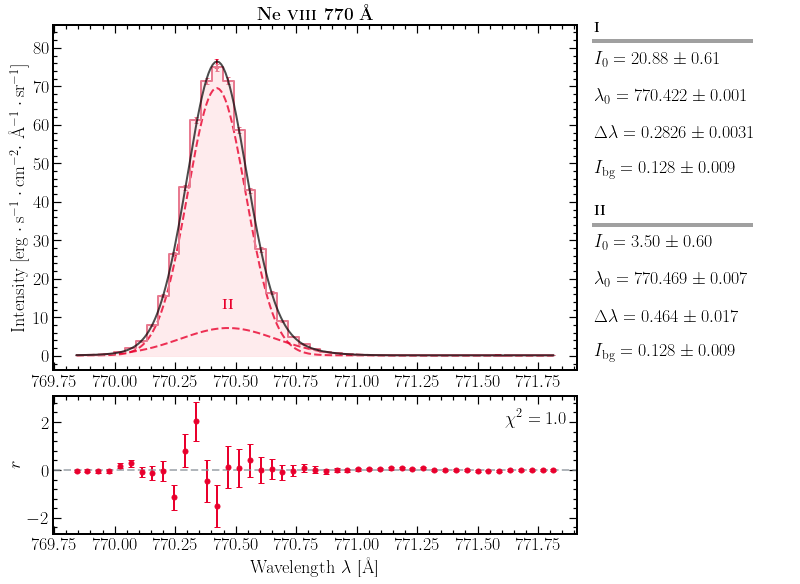

In [22]:
NeVIII_770_fit_double_model = SpectrumFitCustom(data=int_NeVIII_770,wvl=wvl_NeVIII_770,err=err_NeVIII_770,
                                      same_width=False,line_number=2,line_wvl_init=[770.4,770.4],
                                      int_max_init=[70,10],fwhm_init=[0.3,0.6])
#NeVIII_770_fit_model.plot(plot_fit=False,plot_params=False)
NeVIII_770_fit_double_model.run_lse(absolute_sigma=True)
NeVIII_770_fit_double_model.plot(plot_title=r"\textbf{Ne \textsc{viii} 770 \mbox{\AA}}",plot_hmc=False,
                                 xlabel=r"Wavelength $\lambda$ [\mbox{\AA}]",
                               ylabel=r"Intensity $\mathrm{[erg\cdot s^{-1}\cdot cm^{-2}\cdot}$ \mbox{\AA}$\mathrm{^{-1}\cdot sr^{-1}]}$")
print("FWHM after removing instrumental broadening: ",
con_width_funct_4(1,NeVIII_770_fit_double_model.line_wvl_fit,1,NeVIII_770_fit_double_model.fwhm_fit*1000,DET_B=True))

/Users/yjzhu/Desktop/Solar/MyPy/juanfit.py:477: UserWarning: Use custom function in the fitting. Will not plot fitted parameters.
  warn("Use custom function in the fitting. Will not plot fitted parameters.")


[7.70426952e+02 2.28087239e+01 2.89250004e-01 8.04020359e+00
 1.36972343e-01]


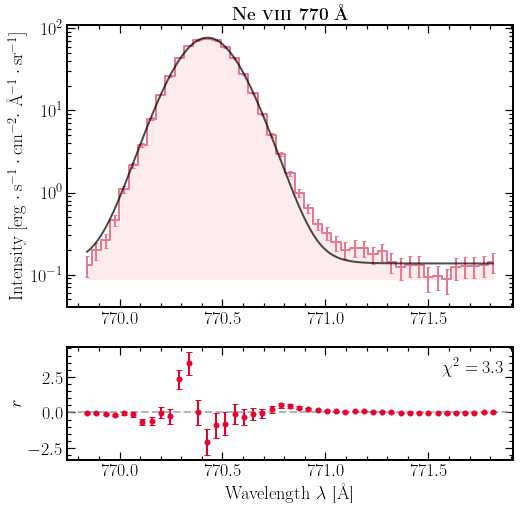

In [23]:
NeVIII_770_fit_kappa_model = SpectrumFitCustom(data=int_NeVIII_770,wvl=wvl_NeVIII_770,err=err_NeVIII_770,
                                      custom_func=kappa_func,
                                      custom_init=[770.4,20,0.25,3,0.1])
#NeVIII_770_fit_model.plot(plot_fit=False,plot_params=False)
NeVIII_770_fit_kappa_model.run_lse(absolute_sigma=True)
ax = NeVIII_770_fit_kappa_model.plot(plot_title=r"\textbf{Ne \textsc{viii} 770 \mbox{\AA}}",plot_hmc=False,
                                 xlabel=r"Wavelength $\lambda$ [\mbox{\AA}]",
                               ylabel=r"Intensity $\mathrm{[erg\cdot s^{-1}\cdot cm^{-2}\cdot}$ \mbox{\AA}$\mathrm{^{-1}\cdot sr^{-1}]}$")
ax.set_yscale("log")
print(NeVIII_770_fit_kappa_model.custom_fit)

<AxesSubplot:title={'center':'\\textbf{Ne \\textsc{viii} 770 \\mbox{\\AA}}'}, ylabel='Intensity $\\mathrm{[erg\\cdot s^{-1}\\cdot cm^{-2}\\cdot}$ \\mbox{\\AA}$\\mathrm{^{-1}\\cdot sr^{-1}]}$'>

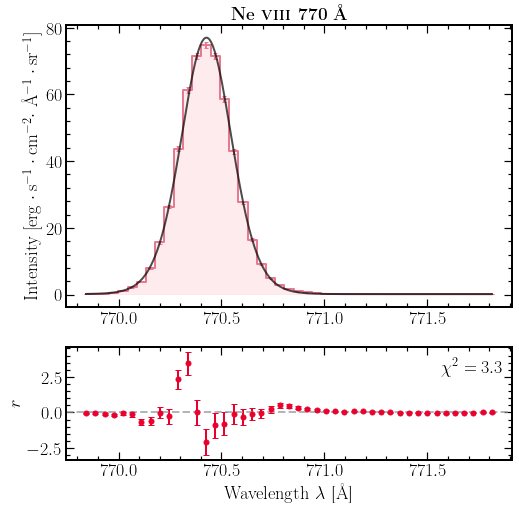

In [24]:
NeVIII_770_fit_kappa_model.plot(plot_title=r"\textbf{Ne \textsc{viii} 770 \mbox{\AA}}",plot_hmc=False,
                                 xlabel=r"Wavelength $\lambda$ [\mbox{\AA}]",
                               ylabel=r"Intensity $\mathrm{[erg\cdot s^{-1}\cdot cm^{-2}\cdot}$ \mbox{\AA}$\mathrm{^{-1}\cdot sr^{-1}]}$")

In [25]:
NeVIII_780_slice = (735,810)
wvl_NeVIII_780 = wvl_375[NeVIII_780_slice[0]:NeVIII_780_slice[1]]
radiometry_NeVIII_780 = radiometry(1,wvl_NeVIII_780,1,np.ones_like(wvl_NeVIII_780),bare=True,kbr=False,photons=False,watts=True,det_a=False,
                                det_b=True,joint=False,separate=True)*1.e3

int_NeVIII_780 = np.average(sumer_375_window[-30:,NeVIII_780_slice[0]:NeVIII_780_slice[1]],axis=0)*radiometry_NeVIII_780
err_NeVIII_780 = np.sqrt(np.sum(300*sumer_375_window[-30:,NeVIII_780_slice[0]:NeVIII_780_slice[1]],
                        axis=0))/30/300*radiometry_NeVIII_780

/Users/yjzhu/Desktop/Solar/MyPy/sumerpy.py:457: UserWarning: No test phase set by default.
  warn("No test phase set by default.")


FWHM after removing instrumental broadening:  [249.94397317]


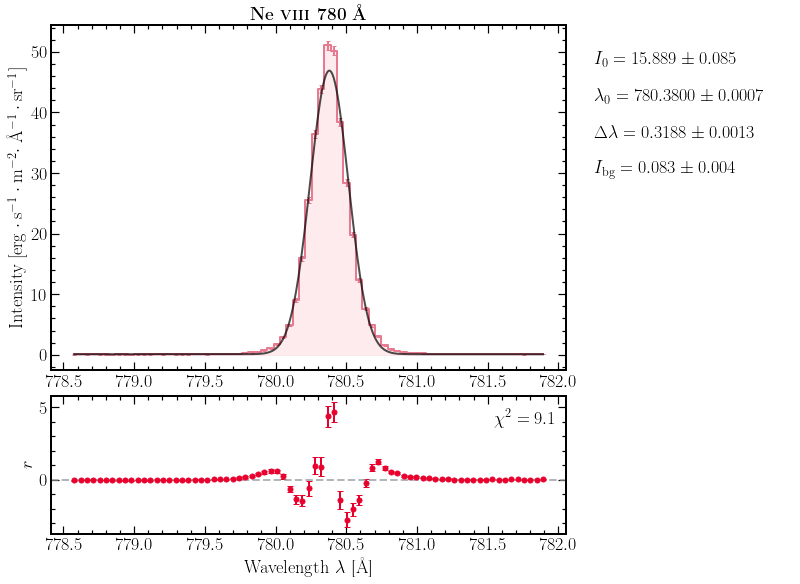

In [26]:
NeVIII_780_fit_model = SpectrumFitCustom(data=int_NeVIII_780,wvl=wvl_NeVIII_780,err=err_NeVIII_780,
                                      same_width=True,line_number=1,line_wvl_init=[780.4],
                                      int_max_init=[50],fwhm_init=[0.3])
#NeVIII_780_fit_model.plot(plot_fit=False,plot_params=False)
NeVIII_780_fit_model.run_lse(absolute_sigma=True)
NeVIII_780_fit_model.plot(plot_title=r"\textbf{Ne \textsc{viii} 780 \mbox{\AA}}",plot_hmc=False,
                                 xlabel=r"Wavelength $\lambda$ [\mbox{\AA}]",
                               ylabel=r"Intensity $\mathrm{[erg\cdot s^{-1}\cdot m^{-2}\cdot}$ \mbox{\AA}$\mathrm{^{-1}\cdot sr^{-1}]}$")
print("FWHM after removing instrumental broadening: ",
con_width_funct_4(1,NeVIII_780_fit_model.line_wvl_fit,1,NeVIII_780_fit_model.fwhm_fit*1000,DET_B=True))

<AxesSubplot:title={'center':'\\textbf{Ne \\textsc{viii} 780 \\mbox{\\AA}}'}, ylabel='Intensity $\\mathrm{[erg\\cdot s^{-1}\\cdot cm^{-2}\\cdot}$ \\mbox{\\AA}$\\mathrm{^{-1}\\cdot sr^{-1}]}$'>

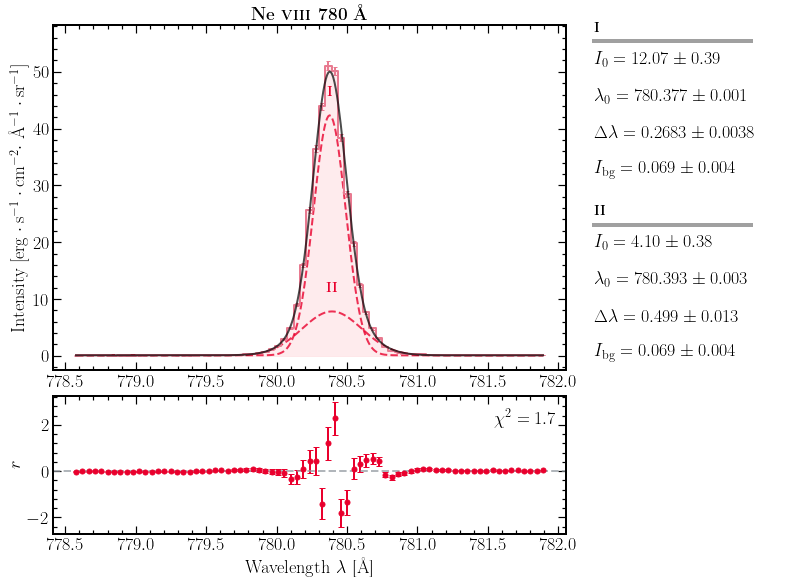

In [27]:
NeVIII_780_fit_double_model = SpectrumFitCustom(data=int_NeVIII_780,wvl=wvl_NeVIII_780,err=err_NeVIII_780,
                                      same_width=False,line_number=2,line_wvl_init=[780.4,780.4],
                                      int_max_init=[50,5],fwhm_init=[0.25,0.4])
#NeVIII_780_fit_model.plot(plot_fit=False,plot_params=False)
NeVIII_780_fit_double_model.run_lse(absolute_sigma=True)
NeVIII_780_fit_double_model.plot(plot_title=r"\textbf{Ne \textsc{viii} 780 \mbox{\AA}}",plot_hmc=False,
                                 xlabel=r"Wavelength $\lambda$ [\mbox{\AA}]",
                               ylabel=r"Intensity $\mathrm{[erg\cdot s^{-1}\cdot cm^{-2}\cdot}$ \mbox{\AA}$\mathrm{^{-1}\cdot sr^{-1}]}$")

/Users/yjzhu/Desktop/Solar/MyPy/juanfit.py:477: UserWarning: Use custom function in the fitting. Will not plot fitted parameters.
  warn("Use custom function in the fitting. Will not plot fitted parameters.")


[7.80379684e+02 1.39224763e+01 2.79315522e-01 3.56044796e+00
 6.28964644e-02]


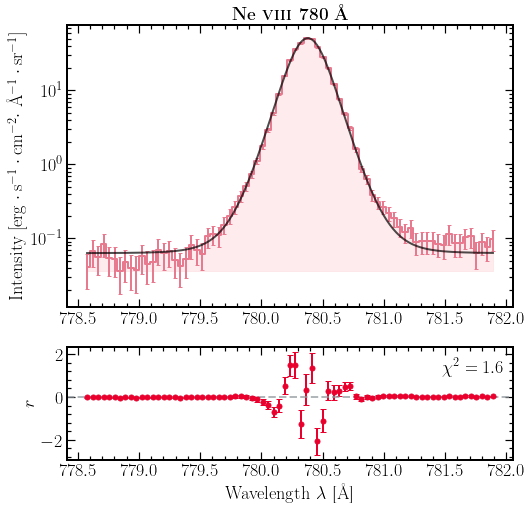

In [28]:
NeVIII_780_fit_kappa_model = SpectrumFitCustom(data=int_NeVIII_780,wvl=wvl_NeVIII_780,err=err_NeVIII_780,
                                      custom_func=kappa_func,
                                      custom_init=[780.3,20,0.25,3,0.1])
#NeVIII_770_fit_model.plot(plot_fit=False,plot_params=False)
NeVIII_780_fit_kappa_model.run_lse(absolute_sigma=True)
ax = NeVIII_780_fit_kappa_model.plot(plot_title=r"\textbf{Ne \textsc{viii} 780 \mbox{\AA}}",plot_hmc=False,
                                 xlabel=r"Wavelength $\lambda$ [\mbox{\AA}]",
                               ylabel=r"Intensity $\mathrm{[erg\cdot s^{-1}\cdot cm^{-2}\cdot}$ \mbox{\AA}$\mathrm{^{-1}\cdot sr^{-1}]}$")
ax.set_yscale("log")
print(NeVIII_780_fit_kappa_model.custom_fit)

### Figure 15b
<a id='figure15b'></a>

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:163: UserWarning: FixedFormatter should only be used together with FixedLocator
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:164: UserWarning: FixedFormatter should only be used together with FixedLocator


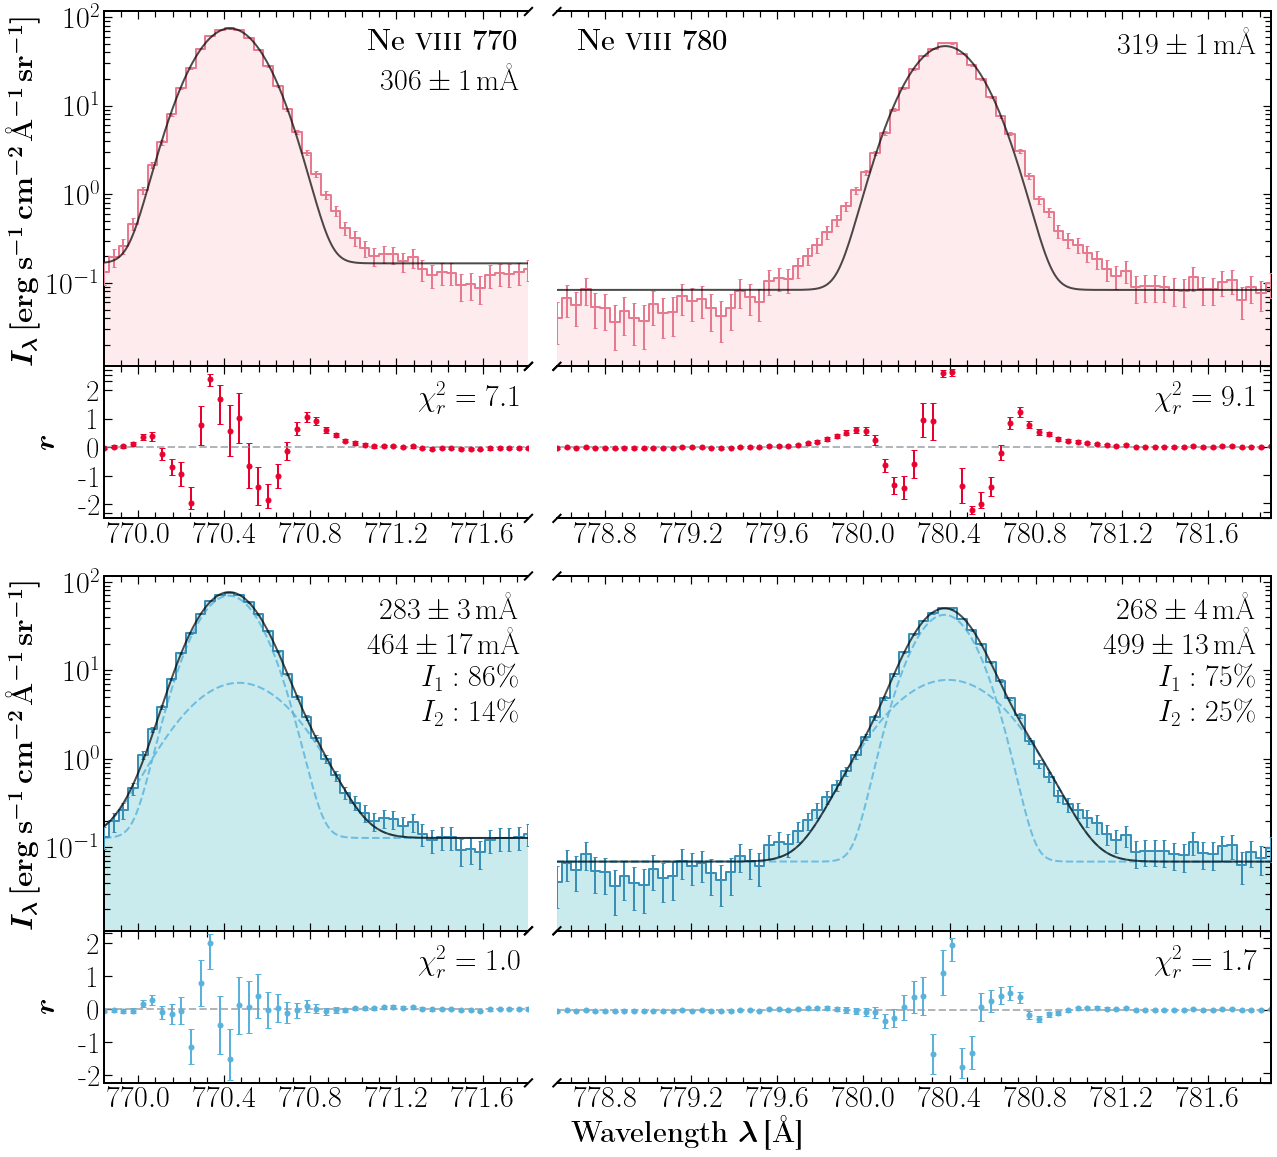

In [29]:
fig = plt.figure(figsize=(18,16),constrained_layout=False)
gs_left = 0.08
gs_right = 0.98
gs1_top = 0.99
gs1_bottom = 0.55
gs2_top = 0.50
gs2_bottom = 0.06
gs1 = fig.add_gridspec(nrows=10, ncols=1, left=gs_left, right=gs_right,bottom=gs1_bottom,top=gs1_top,
                    hspace=0.)
gs2 = fig.add_gridspec(nrows=10, ncols=1, left=gs_left, right=gs_right,bottom=gs2_bottom,top=gs2_top,
                    hspace=0.)

bax1_res = brokenaxes(xlims=((wvl_NeVIII_770[0], wvl_NeVIII_770[-1]), (wvl_NeVIII_780[0], wvl_NeVIII_780[-1])),
                     subplot_spec=gs1[7:, :],despine=False,wspace=0.05,d=0.004) 
bax1_fit = brokenaxes(xlims=((wvl_NeVIII_770[0], wvl_NeVIII_770[-1]), (wvl_NeVIII_780[0], wvl_NeVIII_780[-1])),
                     subplot_spec=gs1[:7, :],despine=False,wspace=0.05,d=0.004) 

bax2_res = brokenaxes(xlims=((wvl_NeVIII_770[0], wvl_NeVIII_770[-1]), (wvl_NeVIII_780[0], wvl_NeVIII_780[-1])),
                     subplot_spec=gs2[7:, :],despine=False,wspace=0.05,d=0.004) 
bax2_fit = brokenaxes(xlims=((wvl_NeVIII_770[0], wvl_NeVIII_770[-1]), (wvl_NeVIII_780[0], wvl_NeVIII_780[-1])),
                     subplot_spec=gs2[:7, :],despine=False,wspace=0.05,d=0.004) 

ln1 = bax1_fit.errorbar(NeVIII_770_fit_model.wvl,NeVIII_770_fit_model.data,yerr = NeVIII_770_fit_model.err,
                            ds='steps-mid',color=colors_red[0],capsize=2,label = r"$I_{\rm obs}$",lw=2,zorder=15)

ln2 = bax1_fit.errorbar(NeVIII_780_fit_model.wvl,NeVIII_780_fit_model.data,yerr = NeVIII_780_fit_model.err,
                            ds='steps-mid',color=colors_red[0],capsize=2,label = r"$I_{\rm obs}$",lw=2,zorder=15)

bax1_fit.fill_between(NeVIII_770_fit_model.wvl,bax1_fit.axs[0].get_ylim()[0],
                        NeVIII_770_fit_model.data,step='mid',color=colors_red[1],alpha=0.6)
bax1_fit.fill_between(NeVIII_780_fit_model.wvl,bax1_fit.axs[0].get_ylim()[0],
                        NeVIII_780_fit_model.data,step='mid',color=colors_red[1],alpha=0.6)

NeVIII_770_single_fit, NeVIII_770_single_res = NeVIII_770_fit_model.get_fit_and_res()
NeVIII_780_single_fit, NeVIII_780_single_res = NeVIII_780_fit_model.get_fit_and_res()

ln1_fit = bax1_fit.plot(NeVIII_770_fit_model.wvl_plot,NeVIII_770_single_fit,color=colors_red[2],ls="-",label = r"$I_{\rm fit}$",lw=2,
                            zorder=16,alpha=0.7)

ln2_fit = bax1_fit.plot(NeVIII_780_fit_model.wvl_plot,NeVIII_780_single_fit,color=colors_red[2],ls="-",label = r"$I_{\rm fit}$",lw=2,
                            zorder=16,alpha=0.7)

bax1_fit.axs[0].text(0.98,0.95,r"\textbf{Ne \textsc{viii} 770}",fontsize=fontsize,ha="right",va="top",
                        transform=bax1_fit.axs[0].transAxes)  
bax1_fit.axs[0].text(0.98,0.85,
r"${:.0f}\pm{:.0f}\,\si{{m\angstrom}}$".format(NeVIII_770_fit_model.fwhm_fit*1e3,NeVIII_770_fit_model.fwhm_err*1e3),
ha="right",va="top",fontsize=fontsize,transform=bax1_fit.axs[0].transAxes)
bax1_fit.axs[1].text(0.98,0.95,
r"${:.0f}\pm{:.0f}\,\si{{m\angstrom}}$".format(NeVIII_780_fit_model.fwhm_fit*1e3,NeVIII_780_fit_model.fwhm_err*1e3),
ha="right",va="top",fontsize=fontsize,transform=bax1_fit.axs[1].transAxes)  
bax1_fit.axs[1].text(0.03,0.95,r"\textbf{Ne \textsc{viii} 780}",fontsize=fontsize,ha="left",va="top",
                        transform=bax1_fit.axs[1].transAxes)  



bax1_res.errorbar(NeVIII_770_fit_model.wvl_tofit,NeVIII_770_single_res,NeVIII_770_fit_model.err_tofit,ds='steps-mid',color=colors_red[3],capsize=3,
                lw=2,ls="none",marker="o",markersize=5)
NeVIII_770_single_chi2 = np.sum((NeVIII_770_single_res/NeVIII_770_fit_model.err_tofit)**2)/NeVIII_770_fit_model.dof
bax1_res.axs[0].text(0.98,0.9,r"$\chi_r^2 = {:.1f}$".format(NeVIII_770_single_chi2),fontsize=fontsize,
            ha="right",va="top",transform=bax1_res.axs[0].transAxes)


bax1_res.errorbar(NeVIII_780_fit_model.wvl_tofit,NeVIII_780_single_res,NeVIII_780_fit_model.err_tofit,ds='steps-mid',color=colors_red[3],capsize=3,
                lw=2,ls="none",marker="o",markersize=5)
NeVIII_780_single_chi2 = np.sum((NeVIII_780_single_res/NeVIII_780_fit_model.err_tofit)**2)/NeVIII_780_fit_model.dof
bax1_res.axs[1].text(0.98,0.9,r"$\chi_r^2 = {:.1f}$".format(NeVIII_780_single_chi2),fontsize=fontsize,
            ha="right",va="top",transform=bax1_res.axs[1].transAxes)

bax1_res.axhline(0,ls="--",lw=2,color="#91989F",alpha=0.7) 

ln3 = bax2_fit.errorbar(NeVIII_770_fit_model.wvl,NeVIII_770_fit_model.data,yerr = NeVIII_770_fit_model.err,
                            ds='steps-mid',color=colors_blue[0],capsize=2,label = r"$I_{\rm obs}$",lw=2,zorder=15)

ln4 = bax2_fit.errorbar(NeVIII_780_fit_model.wvl,NeVIII_780_fit_model.data,yerr = NeVIII_780_fit_model.err,
                            ds='steps-mid',color=colors_blue[0],capsize=2,label = r"$I_{\rm obs}$",lw=2,zorder=15)

bax2_fit.fill_between(NeVIII_770_fit_model.wvl,bax1_fit.axs[0].get_ylim()[0],
                        NeVIII_770_fit_model.data,step='mid',color=colors_blue[1],alpha=0.6)
bax2_fit.fill_between(NeVIII_780_fit_model.wvl,bax1_fit.axs[0].get_ylim()[0],
                        NeVIII_780_fit_model.data,step='mid',color=colors_blue[1],alpha=0.6)

NeVIII_770_double_fit, NeVIII_770_double_res = NeVIII_770_fit_double_model.get_fit_and_res()
NeVIII_780_double_fit, NeVIII_780_double_res = NeVIII_780_fit_double_model.get_fit_and_res()
NeVIII_770_double_line_profiles = NeVIII_770_fit_double_model.get_each_profile()
NeVIII_780_double_line_profiles = NeVIII_780_fit_double_model.get_each_profile()


ln3_fit = bax2_fit.plot(NeVIII_770_fit_double_model.wvl_plot,NeVIII_770_double_fit,color=colors_blue[2],ls="-",label = r"$I_{\rm fit}$",lw=2,
                            zorder=16,alpha=0.7)

ln4_fit = bax2_fit.plot(NeVIII_780_fit_double_model.wvl_plot,NeVIII_780_double_fit,color=colors_blue[2],ls="-",label = r"$I_{\rm fit}$",lw=2,
                            zorder=16,alpha=0.7)

for NeVIII_770_double_line_profile_ in NeVIII_770_double_line_profiles:
    bax2_fit.plot(NeVIII_770_fit_double_model.wvl_plot,NeVIII_770_double_line_profile_,lw=2,alpha=0.8,ls="--",color="#58B2DC")

for NeVIII_780_double_line_profile_ in NeVIII_780_double_line_profiles:
    bax2_fit.plot(NeVIII_780_fit_double_model.wvl_plot,NeVIII_780_double_line_profile_,lw=2,alpha=0.8,ls="--",color="#58B2DC")

    
bax2_fit.axs[0].text(0.98,0.95,
r"${:.0f}\pm{:.0f}\,\si{{m\angstrom}}$".format(NeVIII_770_fit_double_model.fwhm_fit[0]*1e3,NeVIII_770_fit_double_model.fwhm_err[0]*1e3),
ha="right",va="top",fontsize=fontsize,transform=bax2_fit.axs[0].transAxes)

bax2_fit.axs[0].text(0.98,0.85,
r"${:.0f}\pm{:.0f}\,\si{{m\angstrom}}$".format(NeVIII_770_fit_double_model.fwhm_fit[1]*1e3,NeVIII_770_fit_double_model.fwhm_err[1]*1e3),
ha="right",va="top",fontsize=fontsize,transform=bax2_fit.axs[0].transAxes)

bax2_fit.axs[0].text(0.98,0.75,
r"$I_1 : {:.0f}\%$".format(NeVIII_770_fit_double_model.int_total_fit[0]/np.sum(NeVIII_770_fit_double_model.int_total_fit)*100),
ha="right",va="top",fontsize=fontsize,transform=bax2_fit.axs[0].transAxes)

bax2_fit.axs[0].text(0.98,0.65,
r"$I_2 : {:.0f}\%$".format(NeVIII_770_fit_double_model.int_total_fit[1]/np.sum(NeVIII_770_fit_double_model.int_total_fit)*100),
ha="right",va="top",fontsize=fontsize,transform=bax2_fit.axs[0].transAxes)


bax2_fit.axs[1].text(0.98,0.95,
r"${:.0f}\pm{:.0f}\,\si{{m\angstrom}}$".format(NeVIII_780_fit_double_model.fwhm_fit[0]*1e3,NeVIII_780_fit_double_model.fwhm_err[0]*1e3),
ha="right",va="top",fontsize=fontsize,transform=bax2_fit.axs[1].transAxes)

bax2_fit.axs[1].text(0.98,0.85,
r"${:.0f}\pm{:.0f}\,\si{{m\angstrom}}$".format(NeVIII_780_fit_double_model.fwhm_fit[1]*1e3,NeVIII_780_fit_double_model.fwhm_err[1]*1e3),
ha="right",va="top",fontsize=fontsize,transform=bax2_fit.axs[1].transAxes)

bax2_fit.axs[1].text(0.98,0.75,
r"$I_1 : {:.0f}\%$".format(NeVIII_780_fit_double_model.int_total_fit[0]/np.sum(NeVIII_780_fit_double_model.int_total_fit)*100),
ha="right",va="top",fontsize=fontsize,transform=bax2_fit.axs[1].transAxes)

bax2_fit.axs[1].text(0.98,0.65,
r"$I_2 : {:.0f}\%$".format(NeVIII_780_fit_double_model.int_total_fit[1]/np.sum(NeVIII_780_fit_double_model.int_total_fit)*100),
ha="right",va="top",fontsize=fontsize,transform=bax2_fit.axs[1].transAxes)

bax2_res.errorbar(NeVIII_770_fit_double_model.wvl_tofit,NeVIII_770_double_res,NeVIII_770_fit_double_model.err_tofit,ds='steps-mid',color=colors_blue[3],capsize=3,
                lw=2,ls="none",marker="o",markersize=5)
NeVIII_770_double_chi2 = np.sum((NeVIII_770_double_res/NeVIII_770_fit_double_model.err_tofit)**2)/NeVIII_770_fit_double_model.dof
bax2_res.axs[0].text(0.98,0.9,r"$\chi_r^2 = {:.1f}$".format(NeVIII_770_double_chi2),fontsize=fontsize,
            ha="right",va="top",transform=bax2_res.axs[0].transAxes)

bax2_res.errorbar(NeVIII_780_fit_double_model.wvl_tofit,NeVIII_780_double_res,NeVIII_780_fit_double_model.err_tofit,ds='steps-mid',color=colors_blue[3],capsize=3,
                lw=2,ls="none",marker="o",markersize=5)
NeVIII_780_double_chi2 = np.sum((NeVIII_780_double_res/NeVIII_780_fit_double_model.err_tofit)**2)/NeVIII_780_fit_double_model.dof
bax2_res.axs[1].text(0.98,0.9,r"$\chi_r^2 = {:.1f}$".format(NeVIII_780_double_chi2),fontsize=fontsize,
            ha="right",va="top",transform=bax2_res.axs[1].transAxes)

bax2_res.axhline(0,ls="--",lw=2,color="#91989F",alpha=0.7) 


bax2_res.set_xlabel(r"\textbf{Wavelength} $\boldsymbol{\lambda\,}$\textbf{[\mbox{\AA}]}",fontsize=fontsize,labelpad=30)
for bax_res_ in (bax1_res, bax2_res):
    bax_res_.set_yscale("symlog")
    bax_res_.set_ylabel(r"$\boldsymbol{r}$",fontsize=fontsize,labelpad=40)
    bax_res_.axs[1].yaxis.set_tick_params(labelleft=False,left=False,labelright=False,right=True,which="both")
    bax_res_.axs[0].yaxis.set_major_formatter(ticker.ScalarFormatter())
    bax_res_.axs[1].set_yticks(bax_res_.axs[0].get_yticks())
    for ax_ in bax_res_.axs:
        ax_.tick_params(labeltop=False,top=True,bottom=True,direction="in",which="both",
                        labelsize=labelsize) 
        ax_.tick_params(which="major",length=8,width=1.2)
        ax_.tick_params(which="minor",length=6,width=1.2)
        ax_.xaxis.set_minor_locator(ticker.AutoMinorLocator(5))
        ax_.xaxis.set_major_locator(ticker.MultipleLocator(0.4))
bax1_res.axs[0].set_yticklabels(['','','-2','-1','0','1','2','','',''])
bax2_res.axs[0].set_yticklabels(['','-2','-1','0','1','2',''])
for bax_fit_ in (bax1_fit, bax2_fit):
    bax_fit_.set_ylabel(r"$\boldsymbol{I_\lambda\,\mathrm{[erg\,s^{-1}\,cm^{-2}}}$\,\textbf{\mbox{\AA}}$\boldsymbol{\mathrm{^{-1}\,sr^{-1}}]}$",
                    fontsize=fontsize,labelpad=60)
    bax_fit_.set_yscale("log")
    bax_fit_.axs[1].yaxis.set_tick_params(labelright=False,right=True,which="both")
    for ax_ in bax_fit_.axs:
        ax_.tick_params(labeltop=False,top=True,bottom=True,labelbottom=False,direction="in",
                        which="both",labelsize=labelsize)  
        ax_.tick_params(which="major",length=8,width=1.2)
        ax_.tick_params(which="minor",length=6,width=1.2)
        ax_.xaxis.set_minor_locator(ticker.AutoMinorLocator(5))
        ax_.xaxis.set_major_locator(ticker.MultipleLocator(0.4))

plt.savefig("../../figs/ms/NeVIII_doubleGauss.pdf",format="pdf",dpi=300)
# bax1_fit.axs[1].spines['right'].set_visible(True)
# bax1_fit.axs[1].spines['top'].set_visible(True)


In [30]:
MgX_609_slice = (215,270)
wvl_MgX_609 = wvl_607[MgX_609_slice[0]:MgX_609_slice[1]]
radiometry_MgX_609_bare = radiometry(1,wvl_MgX_609[:-15]/2.,2,np.ones_like(wvl_MgX_609[:-15]),bare=True,kbr=False,photons=False,watts=True,det_a=False,
                                det_b=True,joint=False,separate=True)*1.e3
radiometry_MgX_609_kbr = radiometry(1,wvl_MgX_609[-15:]/2.,2,np.ones_like(wvl_MgX_609[-15:]),bare=False,kbr=True,photons=False,watts=True,det_a=False,
                                det_b=True,joint=False,separate=True)*1.e3
radiometry_MgX_609 = np.concatenate((radiometry_MgX_609_bare,radiometry_MgX_609_kbr))
int_MgX_609 = np.average(sumer_607_window[-30:,MgX_609_slice[0]:MgX_609_slice[1]],axis=0)*radiometry_MgX_609
err_MgX_609 = np.sqrt(np.sum(300*sumer_607_window[-30:,MgX_609_slice[0]:MgX_609_slice[1]],
                        axis=0))/30/300*radiometry_MgX_609

/Users/yjzhu/Desktop/Solar/MyPy/sumerpy.py:457: UserWarning: No test phase set by default.
  warn("No test phase set by default.")


FWHM after removing instrumental broadening:  [149.78956068]


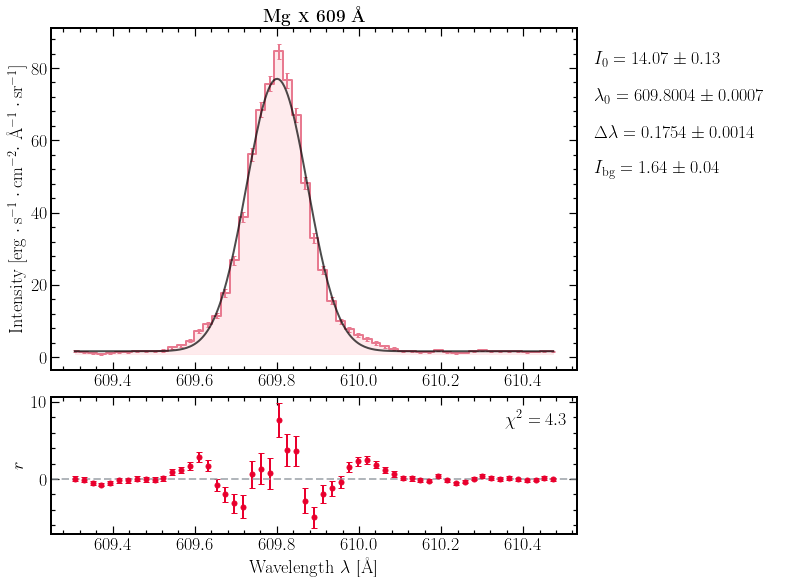

In [31]:
MgX_609_fit_model = SpectrumFitCustom(data=int_MgX_609,wvl=wvl_MgX_609/2.,err=err_MgX_609,
                                      same_width=True,line_number=1,line_wvl_init=[1219.5/2.],
                                      int_max_init=[80],fwhm_init=[0.15])
#MgX_609_fit_model.plot(plot_fit=False,plot_params=False)
#MgX_609_fit_model.run_lse()
MgX_609_fit_model.run_lse(absolute_sigma=True)
MgX_609_fit_model.plot(plot_title=r"\textbf{Mg \textsc{x} 609 \mbox{\AA}}",plot_hmc=False,
                                 xlabel=r"Wavelength $\lambda$ [\mbox{\AA}]",
                               ylabel=r"Intensity $\mathrm{[erg\cdot s^{-1}\cdot cm^{-2}\cdot}$ \mbox{\AA}$\mathrm{^{-1}\cdot sr^{-1}]}$",
                              color_style="Red")
print("FWHM after removing instrumental broadening: ",
con_width_funct_4(1,MgX_609_fit_model.line_wvl_fit,2,MgX_609_fit_model.fwhm_fit*1000,DET_B=True))

<AxesSubplot:title={'center':'\\textbf{Mg \\textsc{x} 609 \\mbox{\\AA}}'}, ylabel='Intensity $\\mathrm{[erg\\cdot s^{-1}\\cdot cm^{-2}\\cdot}$ \\mbox{\\AA}$\\mathrm{^{-1}\\cdot sr^{-1}]}$'>

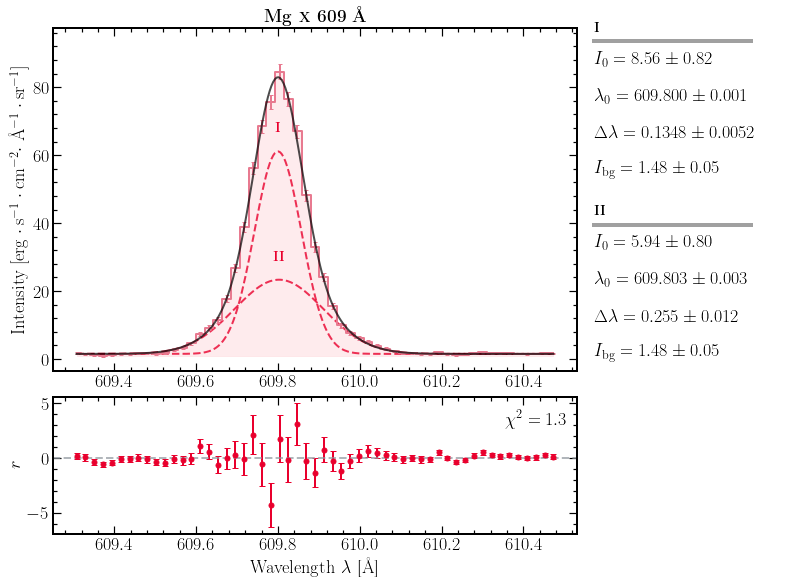

In [32]:
MgX_609_fit_double_model = SpectrumFitCustom(data=int_MgX_609,wvl=wvl_MgX_609/2.,err=err_MgX_609,
                                      same_width=False,line_number=2,line_wvl_init=[1219.5/2.,1219.5/2.],
                                      int_max_init=[80,10],fwhm_init=[0.3,0.6])
#MgX_609_fit_model.plot(plot_fit=False,plot_params=False)
MgX_609_fit_double_model.run_lse(absolute_sigma=True)
# MgX_609_fit_model.run_HahnMC(n_chain=10000)
MgX_609_fit_double_model.plot(plot_title=r"\textbf{Mg \textsc{x} 609 \mbox{\AA}}",plot_hmc=False,
                                 xlabel=r"Wavelength $\lambda$ [\mbox{\AA}]",
                               ylabel=r"Intensity $\mathrm{[erg\cdot s^{-1}\cdot cm^{-2}\cdot}$ \mbox{\AA}$\mathrm{^{-1}\cdot sr^{-1}]}$",
                              color_style="Red")

/Users/yjzhu/Desktop/Solar/MyPy/juanfit.py:477: UserWarning: Use custom function in the fitting. Will not plot fitted parameters.
  warn("Use custom function in the fitting. Will not plot fitted parameters.")


[6.09800696e+02 1.23142747e+01 1.55711205e-01 3.26066497e+00
 1.43175018e+00]


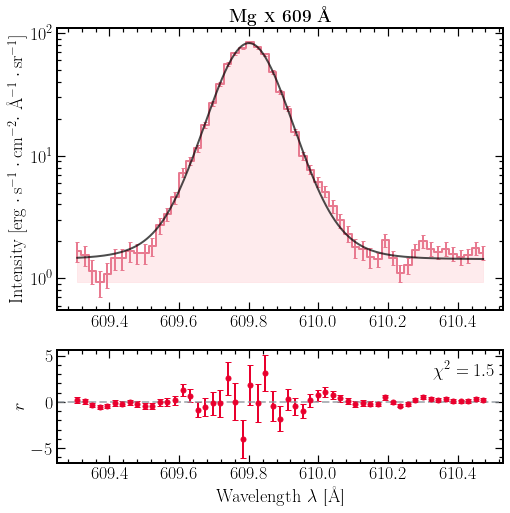

In [33]:
MgX_609_fit_kappa_model = SpectrumFitCustom(data=int_MgX_609,wvl=wvl_MgX_609/2.,err=err_MgX_609,
                                        custom_func=kappa_func,
                                        custom_init=[609.8,20,0.15,3,1])
#MgX_609_fit_model.plot(plot_fit=False,plot_params=False)
MgX_609_fit_kappa_model.run_lse(absolute_sigma=True)
# MgX_609_fit_model.run_HahnMC(n_chain=10000)
ax = MgX_609_fit_kappa_model.plot(plot_title=r"\textbf{Mg \textsc{x} 609 \mbox{\AA}}",plot_hmc=False,
                                 xlabel=r"Wavelength $\lambda$ [\mbox{\AA}]",
                               ylabel=r"Intensity $\mathrm{[erg\cdot s^{-1}\cdot cm^{-2}\cdot}$ \mbox{\AA}$\mathrm{^{-1}\cdot sr^{-1}]}$",
                              color_style="Red")
ax.set_yscale("log")
print(MgX_609_fit_kappa_model.custom_fit)

In [34]:
MgX_624_slice = (915,995)
wvl_MgX_624 = wvl_607[MgX_624_slice[0]:MgX_624_slice[1]]
radiometry_MgX_624 = radiometry(1,wvl_MgX_624/2.,2,np.ones_like(wvl_MgX_624),bare=True,kbr=False,photons=False,watts=True,det_a=False,
                                det_b=True,joint=False,separate=True)*1.e3
int_MgX_624 = np.average(sumer_607_window[-30:,MgX_624_slice[0]:MgX_624_slice[1]],axis=0)*radiometry_MgX_624
err_MgX_624 = np.sqrt(np.sum(300*sumer_607_window[-30:,MgX_624_slice[0]:MgX_624_slice[1]],
                        axis=0))/30/300*radiometry_MgX_624

/Users/yjzhu/Desktop/Solar/MyPy/sumerpy.py:457: UserWarning: No test phase set by default.
  warn("No test phase set by default.")


FWHM after removing instrumental broadening:  [115.52326333 170.94075124]


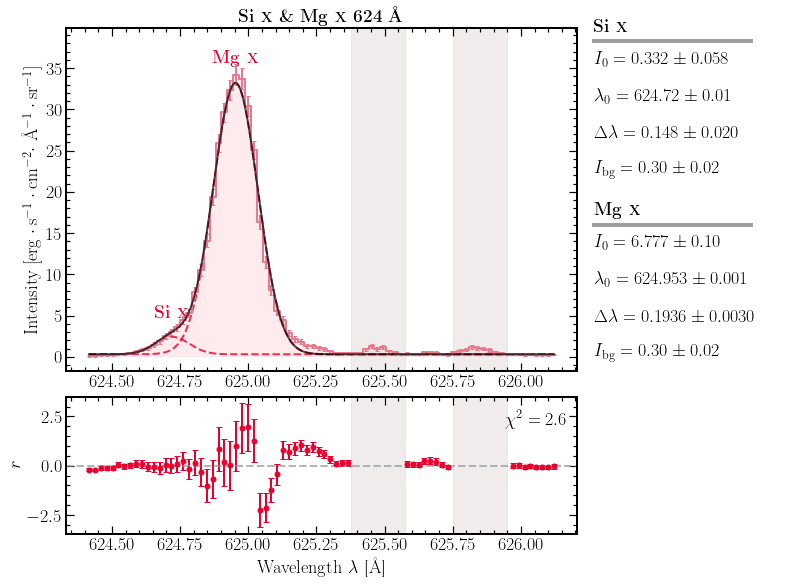

In [35]:
MgX_624_fit_model = SpectrumFitCustom(data=int_MgX_624,wvl=wvl_MgX_624/2.,err=err_MgX_624,
                                      same_width=False,line_number=2,line_wvl_init=[1249.5/2.,1249.9/2.],
                                      int_max_init=[5,35],fwhm_init=[0.2,0.2],mask=[[1250.75/2.,1251.15/2.],[625.75,625.95]])
#SiX_MgX_624_fit_model.plot(plot_fit=False,plot_params=False)
MgX_624_fit_model.run_lse(absolute_sigma=True)
# SiX_MgX_624_fit_model.run_HahnMC(n_chain=10000)
MgX_624_fit_model.plot(plot_title=r"\textbf{Si \textsc{x} \& Mg \textsc{x} 624 \mbox{\AA}}",
                                 xlabel=r"Wavelength $\lambda$ [\mbox{\AA}]",
                                 line_caption = [r"\textbf{Si \textsc{x}}",r"\textbf{Mg \textsc{x}}"],
                               ylabel=r"Intensity $\mathrm{[erg\cdot s^{-1}\cdot cm^{-2}\cdot}$ \mbox{\AA}$\mathrm{^{-1}\cdot sr^{-1}]}$",
                              color_style="Red")
print("FWHM after removing instrumental broadening: ",
con_width_funct_4(1,MgX_624_fit_model.line_wvl_fit,2,MgX_624_fit_model.fwhm_fit*1000,DET_B=True))

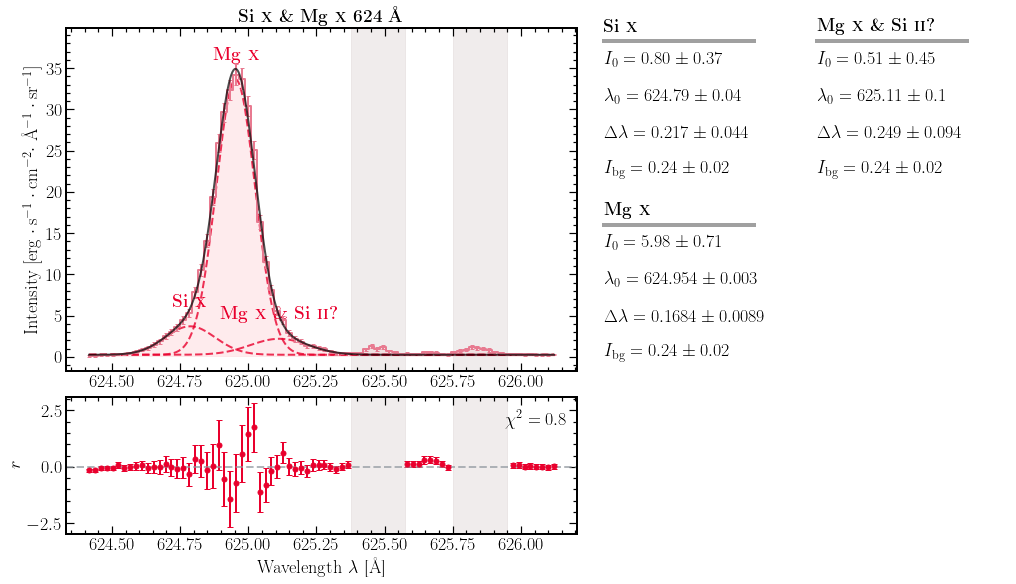

In [36]:
MgX_624_fit_double_model = SpectrumFitCustom(data=int_MgX_624,wvl=wvl_MgX_624/2.,err=err_MgX_624,
                                      same_width=False,line_number=3,line_wvl_init=[1249.5/2.,1249.9/2.,1250.15/2.],
                                      int_max_init=[5,35,4],fwhm_init=[0.16,0.16,0.25],mask=[[1250.75/2.,1251.15/2.],[625.75,625.95]])
#SiX_MgX_624_fit_model.plot(plot_fit=False,plot_params=False)
MgX_624_fit_double_model.run_lse(absolute_sigma=True)
# SiX_MgX_624_fit_model.run_HahnMC(n_chain=10000)
ax = MgX_624_fit_double_model.plot(plot_title=r"\textbf{Si \textsc{x} \& Mg \textsc{x} 624 \mbox{\AA}}",
                                 xlabel=r"Wavelength $\lambda$ [\mbox{\AA}]",
                                 line_caption = [r"\textbf{Si \textsc{x}}",r"\textbf{Mg \textsc{x}}",
                                 r"\textbf{Mg \textsc{x} \& Si \textsc{ii}?}"],
                               ylabel=r"Intensity $\mathrm{[erg\cdot s^{-1}\cdot cm^{-2}\cdot}$ \mbox{\AA}$\mathrm{^{-1}\cdot sr^{-1}]}$",
                              color_style="Red")
#ax.set_yscale("log")

/Users/yjzhu/Desktop/Solar/MyPy/juanfit.py:477: UserWarning: Use custom function in the fitting. Will not plot fitted parameters.
  warn("Use custom function in the fitting. Will not plot fitted parameters.")


[1.86539417e-01 5.87155408e+00 6.24721424e+02 6.24951899e+02
 1.46333823e-01 1.74629201e-01 2.86825464e+00 2.32080412e-01]


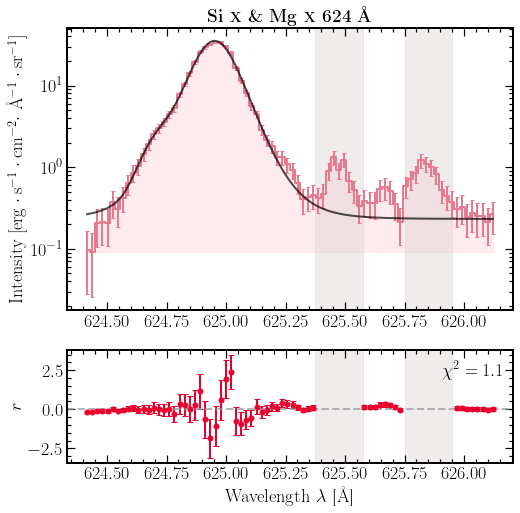

In [37]:
def MgX_624_kappa_func(wvl,int1,int2,wvl1,wvl2,fwhm1,fwhm2,kappa,int_cont):
    return gaussian(wvl,wvl1,int1,fwhm1) + \
            kappa_func(wvl,wvl2,int2,fwhm2,kappa,0) + int_cont
MgX_624_fit_kappa_model = SpectrumFitCustom(data=int_MgX_624,wvl=wvl_MgX_624/2.,err=err_MgX_624,
                                            custom_func=MgX_624_kappa_func,mask=[[1250.75/2.,1251.15/2.],[625.75,625.95]],
                                            custom_init=[0.5,6,624.7,624.9,0.22,0.17,3,0.22])
#SiX_MgX_624_fit_model.plot(plot_fit=False,plot_params=False)
MgX_624_fit_kappa_model.run_lse(absolute_sigma=True)
# SiX_MgX_624_fit_model.run_HahnMC(n_chain=10000)
ax = MgX_624_fit_kappa_model.plot(plot_title=r"\textbf{Si \textsc{x} \& Mg \textsc{x} 624 \mbox{\AA}}",
                                 xlabel=r"Wavelength $\lambda$ [\mbox{\AA}]",
                                 line_caption = [r"\textbf{Si \textsc{x}}",r"\textbf{Mg \textsc{x}}",
                                 r"\textbf{Mg \textsc{x} \& Si \textsc{ii}?}"],
                               ylabel=r"Intensity $\mathrm{[erg\cdot s^{-1}\cdot cm^{-2}\cdot}$ \mbox{\AA}$\mathrm{^{-1}\cdot sr^{-1}]}$",
                              color_style="Red")
ax.set_yscale("log")
print(MgX_624_fit_kappa_model.custom_fit)

### Figure 15c
<a id='figure15c'></a>

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:178: UserWarning: FixedFormatter should only be used together with FixedLocator
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:179: UserWarning: FixedFormatter should only be used together with FixedLocator


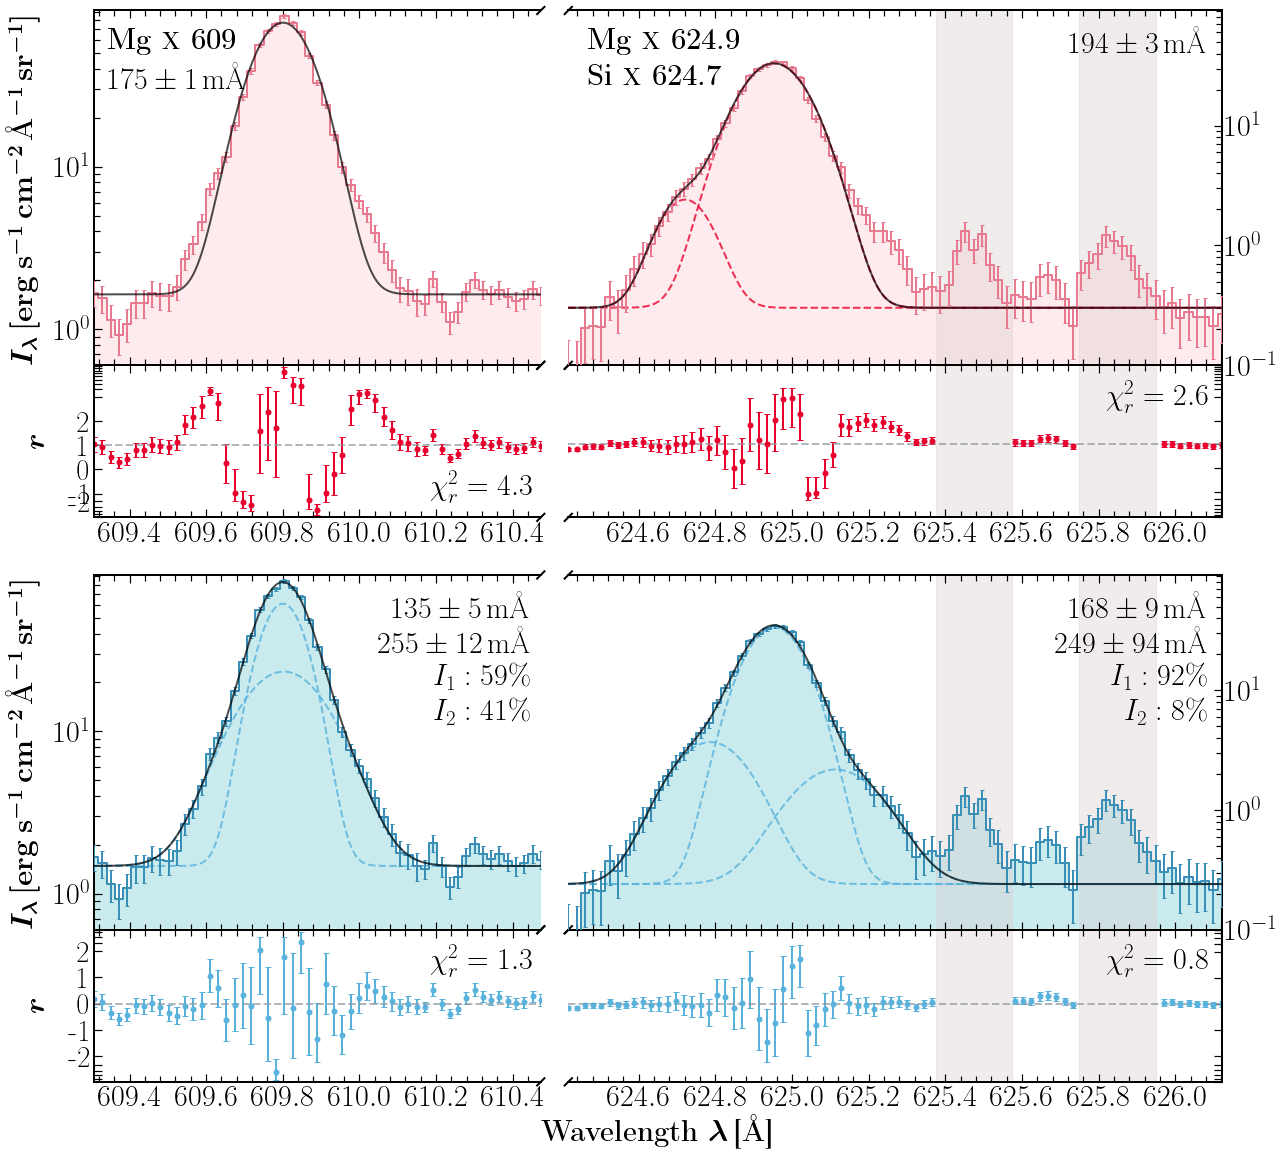

In [38]:
fig = plt.figure(figsize=(18,16),constrained_layout=False)
gs_left = 0.08
gs_right = 0.95
gs1_top = 0.99
gs1_bottom = 0.55
gs2_top = 0.50
gs2_bottom = 0.06
gs1 = fig.add_gridspec(nrows=10, ncols=1, left=gs_left, right=gs_right,bottom=gs1_bottom,top=gs1_top,
                    hspace=0.)
gs2 = fig.add_gridspec(nrows=10, ncols=1, left=gs_left, right=gs_right,bottom=gs2_bottom,top=gs2_top,
                    hspace=0.)

bax1_res = brokenaxes(xlims=((wvl_MgX_609[0]/2., wvl_MgX_609[-1]/2.), (wvl_MgX_624[0]/2., wvl_MgX_624[-1]/2.)),
                     subplot_spec=gs1[7:, :],despine=False,wspace=0.05,d=0.004) 
bax1_fit = brokenaxes(xlims=((wvl_MgX_609[0]/2., wvl_MgX_609[-1]/2.), (wvl_MgX_624[0]/2., wvl_MgX_624[-1]/2.)),
                     subplot_spec=gs1[:7, :],despine=False,wspace=0.05,d=0.004) 

bax2_res = brokenaxes(xlims=((wvl_MgX_609[0]/2., wvl_MgX_609[-1]/2.), (wvl_MgX_624[0]/2., wvl_MgX_624[-1]/2.)),
                     subplot_spec=gs2[7:, :],despine=False,wspace=0.05,d=0.004) 
bax2_fit = brokenaxes(xlims=((wvl_MgX_609[0]/2., wvl_MgX_609[-1]/2.), (wvl_MgX_624[0]/2., wvl_MgX_624[-1]/2.)),
                     subplot_spec=gs2[:7, :],despine=False,wspace=0.05,d=0.004) 

ln1 = bax1_fit.errorbar(MgX_609_fit_model.wvl,MgX_609_fit_model.data,yerr = MgX_609_fit_model.err,
                            ds='steps-mid',color=colors_red[0],capsize=2,label = r"$I_{\rm obs}$",lw=2,zorder=15)

ln2 = bax1_fit.errorbar(MgX_624_fit_model.wvl,MgX_624_fit_model.data,yerr = MgX_624_fit_model.err,
                            ds='steps-mid',color=colors_red[0],capsize=2,label = r"$I_{\rm obs}$",lw=2,zorder=15)

bax1_fit.fill_between(MgX_609_fit_model.wvl,bax1_fit.axs[0].get_ylim()[0],
                        MgX_609_fit_model.data,step='mid',color=colors_red[1],alpha=0.6)
bax1_fit.fill_between(MgX_624_fit_model.wvl,bax1_fit.axs[0].get_ylim()[0],
                        MgX_624_fit_model.data,step='mid',color=colors_red[1],alpha=0.6)

MgX_609_single_fit, MgX_609_single_res = MgX_609_fit_model.get_fit_and_res()
MgX_624_single_fit, MgX_624_single_res = MgX_624_fit_model.get_fit_and_res()

ln1_fit = bax1_fit.plot(MgX_609_fit_model.wvl_plot,MgX_609_single_fit,color=colors_red[2],ls="-",label = r"$I_{\rm fit}$",lw=2,
                            zorder=16,alpha=0.7)

ln2_fit = bax1_fit.plot(MgX_624_fit_model.wvl_plot,MgX_624_single_fit,color=colors_red[2],ls="-",label = r"$I_{\rm fit}$",lw=2,
                            zorder=16,alpha=0.7)

MgX_624_single_line_profiles = MgX_624_fit_model.get_each_profile()

for MgX_624_single_line_profile_ in MgX_624_single_line_profiles:
    bax1_fit.plot(MgX_624_fit_model.wvl_plot,MgX_624_single_line_profile_,lw=2,alpha=0.8,ls="--",color="#E9002D")


bax1_fit.axs[0].text(0.03,0.95,r"\textbf{Mg \textsc{x} 609}",fontsize=fontsize,ha="left",va="top",
                        transform=bax1_fit.axs[0].transAxes)  
bax1_fit.axs[0].text(0.03,0.85,
r"${:.0f}\pm{:.0f}\,\si{{m\angstrom}}$".format(MgX_609_fit_model.fwhm_fit*1e3,MgX_609_fit_model.fwhm_err*1e3),
ha="left",va="top",fontsize=fontsize,transform=bax1_fit.axs[0].transAxes)
bax1_fit.axs[1].text(0.98,0.95,
r"${:.0f}\pm{:.0f}\,\si{{m\angstrom}}$".format(MgX_624_fit_model.fwhm_fit[1]*1e3,MgX_624_fit_model.fwhm_err[1]*1e3),
ha="right",va="top",fontsize=fontsize,transform=bax1_fit.axs[1].transAxes)  
bax1_fit.axs[1].text(0.03,0.95,r"\textbf{Mg \textsc{x} 624.9}",fontsize=fontsize,ha="left",va="top",
                        transform=bax1_fit.axs[1].transAxes)  
bax1_fit.axs[1].text(0.03,0.85,r"\textbf{Si \textsc{x} 624.7}",fontsize=fontsize,ha="left",va="top",
                        transform=bax1_fit.axs[1].transAxes)  


for mask_ in MgX_624_fit_model.mask:
    bax1_fit.axvspan(mask_[0],mask_[1],color=colors_red[4],alpha=0.4)
    bax1_res.axvspan(mask_[0],mask_[1],color=colors_red[4],alpha=0.4)


bax1_res.errorbar(MgX_609_fit_model.wvl_tofit,MgX_609_single_res,MgX_609_fit_model.err_tofit,ds='steps-mid',color=colors_red[3],capsize=3,
                lw=2,ls="none",marker="o",markersize=5)
MgX_609_single_chi2 = np.sum((MgX_609_single_res/MgX_609_fit_model.err_tofit)**2)/MgX_609_fit_model.dof
bax1_res.axs[0].text(0.98,0.1,r"$\chi_r^2 = {:.1f}$".format(MgX_609_single_chi2),fontsize=fontsize,
            ha="right",va="bottom",transform=bax1_res.axs[0].transAxes)


bax1_res.errorbar(MgX_624_fit_model.wvl_tofit,MgX_624_single_res,MgX_624_fit_model.err_tofit,ds='steps-mid',color=colors_red[3],capsize=3,
                lw=2,ls="none",marker="o",markersize=5)
MgX_624_single_chi2 = np.sum((MgX_624_single_res/MgX_624_fit_model.err_tofit)**2)/MgX_624_fit_model.dof
bax1_res.axs[1].text(0.98,0.9,r"$\chi_r^2 = {:.1f}$".format(MgX_624_single_chi2),fontsize=fontsize,
            ha="right",va="top",transform=bax1_res.axs[1].transAxes)

bax1_res.axhline(0,ls="--",lw=2,color="#91989F",alpha=0.7) 

ln3 = bax2_fit.errorbar(MgX_609_fit_model.wvl,MgX_609_fit_model.data,yerr = MgX_609_fit_model.err,
                            ds='steps-mid',color=colors_blue[0],capsize=2,label = r"$I_{\rm obs}$",lw=2,zorder=15)

ln4 = bax2_fit.errorbar(MgX_624_fit_model.wvl,MgX_624_fit_model.data,yerr = MgX_624_fit_model.err,
                            ds='steps-mid',color=colors_blue[0],capsize=2,label = r"$I_{\rm obs}$",lw=2,zorder=15)

bax2_fit.fill_between(MgX_609_fit_model.wvl,bax1_fit.axs[0].get_ylim()[0],
                        MgX_609_fit_model.data,step='mid',color=colors_blue[1],alpha=0.6)
bax2_fit.fill_between(MgX_624_fit_model.wvl,bax1_fit.axs[0].get_ylim()[0],
                        MgX_624_fit_model.data,step='mid',color=colors_blue[1],alpha=0.6)

MgX_609_double_fit, MgX_609_double_res = MgX_609_fit_double_model.get_fit_and_res()
MgX_624_double_fit, MgX_624_double_res = MgX_624_fit_double_model.get_fit_and_res()
MgX_609_double_line_profiles = MgX_609_fit_double_model.get_each_profile()
MgX_624_double_line_profiles = MgX_624_fit_double_model.get_each_profile()


ln3_fit = bax2_fit.plot(MgX_609_fit_double_model.wvl_plot,MgX_609_double_fit,color=colors_blue[2],ls="-",label = r"$I_{\rm fit}$",lw=2,
                            zorder=16,alpha=0.7)

ln4_fit = bax2_fit.plot(MgX_624_fit_double_model.wvl_plot,MgX_624_double_fit,color=colors_blue[2],ls="-",label = r"$I_{\rm fit}$",lw=2,
                            zorder=16,alpha=0.7)

for MgX_609_double_line_profile_ in MgX_609_double_line_profiles:
    bax2_fit.plot(MgX_609_fit_double_model.wvl_plot,MgX_609_double_line_profile_,lw=2,alpha=0.8,ls="--",color="#58B2DC")

for MgX_624_double_line_profile_ in MgX_624_double_line_profiles:
    bax2_fit.plot(MgX_624_fit_double_model.wvl_plot,MgX_624_double_line_profile_,lw=2,alpha=0.8,ls="--",color="#58B2DC")

for mask_ in MgX_624_fit_model.mask:
    bax2_fit.axvspan(mask_[0],mask_[1],color=colors_red[4],alpha=0.4)
    bax2_res.axvspan(mask_[0],mask_[1],color=colors_red[4],alpha=0.4)

    
bax2_fit.axs[0].text(0.98,0.95,
r"${:.0f}\pm{:.0f}\,\si{{m\angstrom}}$".format(MgX_609_fit_double_model.fwhm_fit[0]*1e3,MgX_609_fit_double_model.fwhm_err[0]*1e3),
ha="right",va="top",fontsize=fontsize,transform=bax2_fit.axs[0].transAxes)

bax2_fit.axs[0].text(0.98,0.85,
r"${:.0f}\pm{:.0f}\,\si{{m\angstrom}}$".format(MgX_609_fit_double_model.fwhm_fit[1]*1e3,MgX_609_fit_double_model.fwhm_err[1]*1e3),
ha="right",va="top",fontsize=fontsize,transform=bax2_fit.axs[0].transAxes)

bax2_fit.axs[0].text(0.98,0.75,
r"$I_1 : {:.0f}\%$".format(MgX_609_fit_double_model.int_total_fit[0]/np.sum(MgX_609_fit_double_model.int_total_fit)*100),
ha="right",va="top",fontsize=fontsize,transform=bax2_fit.axs[0].transAxes)

bax2_fit.axs[0].text(0.98,0.65,
r"$I_2 : {:.0f}\%$".format(MgX_609_fit_double_model.int_total_fit[1]/np.sum(MgX_609_fit_double_model.int_total_fit)*100),
ha="right",va="top",fontsize=fontsize,transform=bax2_fit.axs[0].transAxes)


bax2_fit.axs[1].text(0.98,0.95,
r"${:.0f}\pm{:.0f}\,\si{{m\angstrom}}$".format(MgX_624_fit_double_model.fwhm_fit[1]*1e3,MgX_624_fit_double_model.fwhm_err[1]*1e3),
ha="right",va="top",fontsize=fontsize,transform=bax2_fit.axs[1].transAxes)

bax2_fit.axs[1].text(0.98,0.85,
r"${:.0f}\pm{:.0f}\,\si{{m\angstrom}}$".format(MgX_624_fit_double_model.fwhm_fit[2]*1e3,MgX_624_fit_double_model.fwhm_err[2]*1e3),
ha="right",va="top",fontsize=fontsize,transform=bax2_fit.axs[1].transAxes)

bax2_fit.axs[1].text(0.98,0.75,
r"$I_1 : {:.0f}\%$".format(MgX_624_fit_double_model.int_total_fit[1]/np.sum(MgX_624_fit_double_model.int_total_fit[1:])*100),
ha="right",va="top",fontsize=fontsize,transform=bax2_fit.axs[1].transAxes)

bax2_fit.axs[1].text(0.98,0.65,
r"$I_2 : {:.0f}\%$".format(MgX_624_fit_double_model.int_total_fit[2]/np.sum(MgX_624_fit_double_model.int_total_fit[1:])*100),
ha="right",va="top",fontsize=fontsize,transform=bax2_fit.axs[1].transAxes)

bax2_res.errorbar(MgX_609_fit_double_model.wvl_tofit,MgX_609_double_res,MgX_609_fit_double_model.err_tofit,ds='steps-mid',color=colors_blue[3],capsize=3,
                lw=2,ls="none",marker="o",markersize=5)
MgX_609_double_chi2 = np.sum((MgX_609_double_res/MgX_609_fit_double_model.err_tofit)**2)/MgX_609_fit_double_model.dof
bax2_res.axs[0].text(0.98,0.9,r"$\chi_r^2 = {:.1f}$".format(MgX_609_double_chi2),fontsize=fontsize,
            ha="right",va="top",transform=bax2_res.axs[0].transAxes)

bax2_res.errorbar(MgX_624_fit_double_model.wvl_tofit,MgX_624_double_res,MgX_624_fit_double_model.err_tofit,ds='steps-mid',color=colors_blue[3],capsize=3,
                lw=2,ls="none",marker="o",markersize=5)
MgX_624_double_chi2 = np.sum((MgX_624_double_res/MgX_624_fit_double_model.err_tofit)**2)/MgX_624_fit_double_model.dof
bax2_res.axs[1].text(0.98,0.9,r"$\chi_r^2 = {:.1f}$".format(MgX_624_double_chi2),fontsize=fontsize,
            ha="right",va="top",transform=bax2_res.axs[1].transAxes)

bax2_res.axhline(0,ls="--",lw=2,color="#91989F",alpha=0.7) 


bax2_res.set_xlabel(r"\textbf{Wavelength} $\boldsymbol{\lambda\,}$\textbf{[\mbox{\AA}]}",fontsize=fontsize,labelpad=30)
for bax_res_ in (bax1_res, bax2_res):
    bax_res_.set_yscale("symlog")
    bax_res_.set_ylabel(r"$\boldsymbol{r}$",fontsize=fontsize,labelpad=40)
    bax_res_.axs[1].yaxis.set_tick_params(labelleft=False,left=False,labelright=False,right=True,which="both")
    bax_res_.axs[0].yaxis.set_major_formatter(ticker.ScalarFormatter())
    bax_res_.axs[1].set_yticks(bax_res_.axs[0].get_yticks())
    for ax_ in bax_res_.axs:
        ax_.tick_params(labeltop=False,top=True,bottom=True,direction="in",which="both",
                        labelsize=labelsize) 
        ax_.tick_params(which="major",length=8,width=1.2)
        ax_.tick_params(which="minor",length=6,width=1.2)
        ax_.xaxis.set_minor_locator(ticker.AutoMinorLocator(5))
bax1_res.axs[0].set_yticklabels(['','','','','','-2','-1','0','1','2','','',''])
bax2_res.axs[0].set_yticklabels(['','','','','','-2','-1','0','1','2','','',''])
for bax_fit_ in (bax1_fit, bax2_fit):
    bax_fit_.axs[1].set_ylim(bottom=0.1)
    bax_fit_.axs[0].set_ylim(bottom=0.6)
    bax_fit_.set_ylabel(r"$\boldsymbol{I_\lambda\,\mathrm{[erg\,s^{-1}\,cm^{-2}}}$\,\textbf{\mbox{\AA}}$\boldsymbol{\mathrm{^{-1}\,sr^{-1}}]}$",
                    fontsize=fontsize,labelpad=50)
    bax_fit_.set_yscale("log")
    bax_fit_.axs[1].yaxis.set_tick_params(labelright=True,right=True,which="both")
    for ax_ in bax_fit_.axs:
        ax_.tick_params(labeltop=False,top=True,bottom=True,labelbottom=False,direction="in",
                        which="both",labelsize=labelsize)  
        ax_.tick_params(which="major",length=8,width=1.2)
        ax_.tick_params(which="minor",length=6,width=1.2)
        ax_.xaxis.set_minor_locator(ticker.AutoMinorLocator(5))


plt.savefig("../../figs/ms/MgX_doubleGauss.pdf",format="pdf",dpi=300)
# bax1_fit.axs[1].spines['right'].set_visible(True)
# bax1_fit.axs[1].spines['top'].set_visible(True)


In [39]:
NIV_765_slice = (423,460)
wvl_NIV_765 = wvl_375[NIV_765_slice[0]:NIV_765_slice[1]]
radiometry_NIV_765 = radiometry(1,wvl_NIV_765,1,np.ones_like(wvl_NIV_765),bare=False,kbr=True,photons=False,watts=True,det_a=False,
                                det_b=True,joint=False,separate=True)*1.e3
int_NIV_765 = np.average(sumer_375_window[-30:,NIV_765_slice[0]:NIV_765_slice[1]],axis=0)*radiometry_NIV_765
err_NIV_765 = np.sqrt(np.sum(300*sumer_375_window[-30:,NIV_765_slice[0]:NIV_765_slice[1]],
                        axis=0))/30/300*radiometry_NIV_765


/Users/yjzhu/Desktop/Solar/MyPy/sumerpy.py:457: UserWarning: No test phase set by default.
  warn("No test phase set by default.")


FWHM after removing instrumental broadening:  [173.21944617]


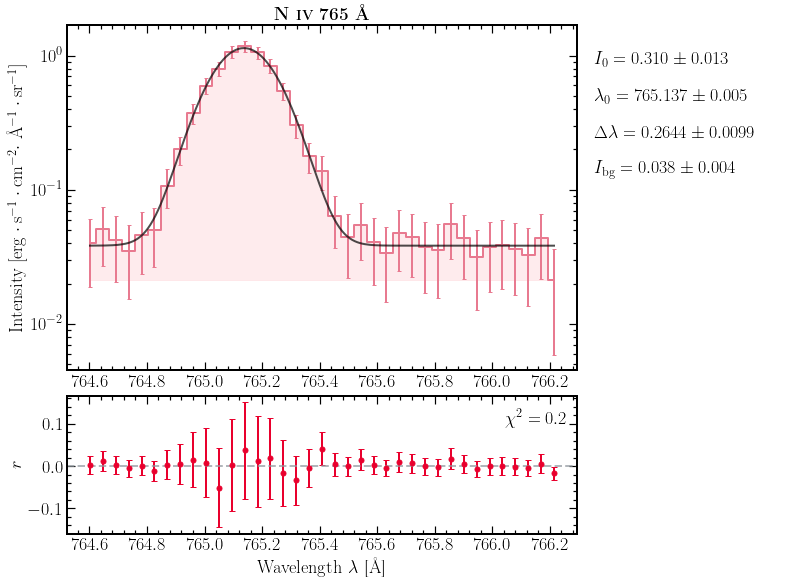

In [40]:
NIV_765_fit_model = SpectrumFitCustom(data=int_NIV_765,wvl=wvl_NIV_765,err=err_NIV_765,
                                      same_width=True,line_number=1,line_wvl_init=[765.12],
                                      int_max_init=[5],fwhm_init=[0.3])
#NIV_765_fit_model.plot(plot_fit=False,plot_params=False)
NIV_765_fit_model.run_lse(absolute_sigma=True)
ax = NIV_765_fit_model.plot(plot_title=r"\textbf{N \textsc{iv} 765 \mbox{\AA}}",plot_hmc=False,
                                 xlabel=r"Wavelength $\lambda$ [\mbox{\AA}]",
                               ylabel=r"Intensity $\mathrm{[erg\cdot s^{-1}\cdot cm^{-2}\cdot}$ \mbox{\AA}$\mathrm{^{-1}\cdot sr^{-1}]}$")
print("FWHM after removing instrumental broadening: ",
con_width_funct_4(1,NIV_765_fit_model.line_wvl_fit,1,NIV_765_fit_model.fwhm_fit*1000,DET_B=True))
ax.set_yscale("log")

In [41]:
OIV_787_slice = (920,960)
wvl_OIV_787 = wvl_375[OIV_787_slice[0]:OIV_787_slice[1]]
radiometry_OIV_787 = radiometry(1,wvl_OIV_787,1,np.ones_like(wvl_OIV_787),bare=True,kbr=False,photons=False,watts=True,det_a=False,
                                det_b=True,joint=False,separate=True)*1.e3
int_OIV_787 = np.average(sumer_375_window[-30:,OIV_787_slice[0]:OIV_787_slice[1]],axis=0)*radiometry_OIV_787
err_OIV_787 = np.sqrt(np.sum(300*sumer_375_window[-30:,OIV_787_slice[0]:OIV_787_slice[1]],
                        axis=0))/30/300*radiometry_OIV_787


/Users/yjzhu/Desktop/Solar/MyPy/sumerpy.py:457: UserWarning: No test phase set by default.
  warn("No test phase set by default.")


FWHM after removing instrumental broadening:  [406.9330101   34.04653031]


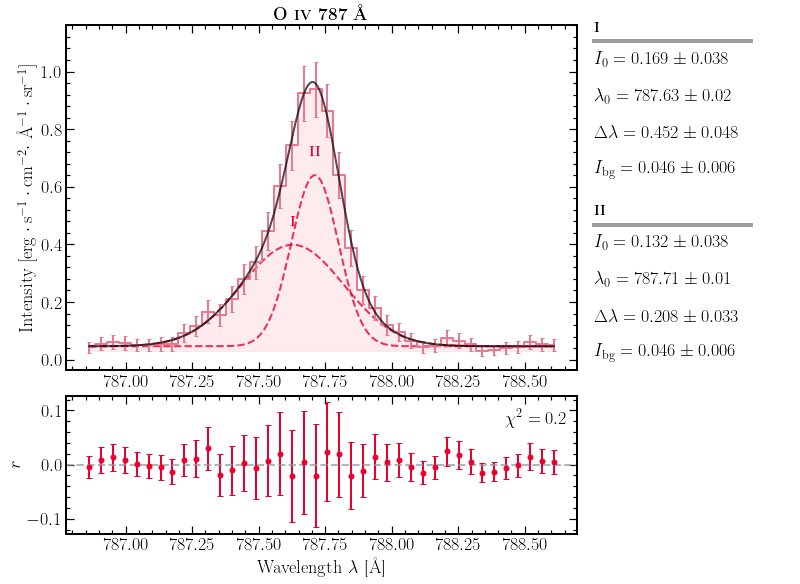

In [42]:
OIV_787_fit_model = SpectrumFitCustom(data=int_OIV_787,wvl=wvl_OIV_787,err=err_OIV_787,
                                      same_width=False,line_number=2,line_wvl_init=[787.55,787.7],
                                      int_max_init=[0.2,1],fwhm_init=[0.3,0.3])
#OIV_787_fit_model.plot(plot_fit=False,plot_params=False)
OIV_787_fit_model.run_lse(absolute_sigma=True)
OIV_787_fit_model.plot(plot_title=r"\textbf{O \textsc{iv} 787 \mbox{\AA}}",plot_hmc=False,
                                 xlabel=r"Wavelength $\lambda$ [\mbox{\AA}]",
                               ylabel=r"Intensity $\mathrm{[erg\cdot s^{-1}\cdot cm^{-2}\cdot}$ \mbox{\AA}$\mathrm{^{-1}\cdot sr^{-1}]}$")
print("FWHM after removing instrumental broadening: ",
con_width_funct_4(1,OIV_787_fit_model.line_wvl_fit,1,OIV_787_fit_model.fwhm_fit*1000,DET_B=True))

In [43]:
MgIX_706_slice = (740,795)
wvl_MgIX_706 = wvl_338[MgIX_706_slice[0]:MgIX_706_slice[1]]
radiometry_MgIX_706 = radiometry(1,wvl_MgIX_706,1,np.ones_like(wvl_MgIX_706),bare=True,kbr=False,photons=False,watts=True,det_a=False,
                                det_b=True,joint=False,separate=True)*1e3
int_MgIX_706 = np.average(sumer_338_window[-30:,MgIX_706_slice[0]:MgIX_706_slice[1]],axis=0)*radiometry_MgIX_706
err_MgIX_706 = np.sqrt(np.sum(300*sumer_338_window[-30:,MgIX_706_slice[0]:MgIX_706_slice[1]],
                        axis=0))/30/300*radiometry_MgIX_706

/Users/yjzhu/Desktop/Solar/MyPy/sumerpy.py:457: UserWarning: No test phase set by default.
  warn("No test phase set by default.")


FWHM after removing instrumental broadening:  [231.26597255]


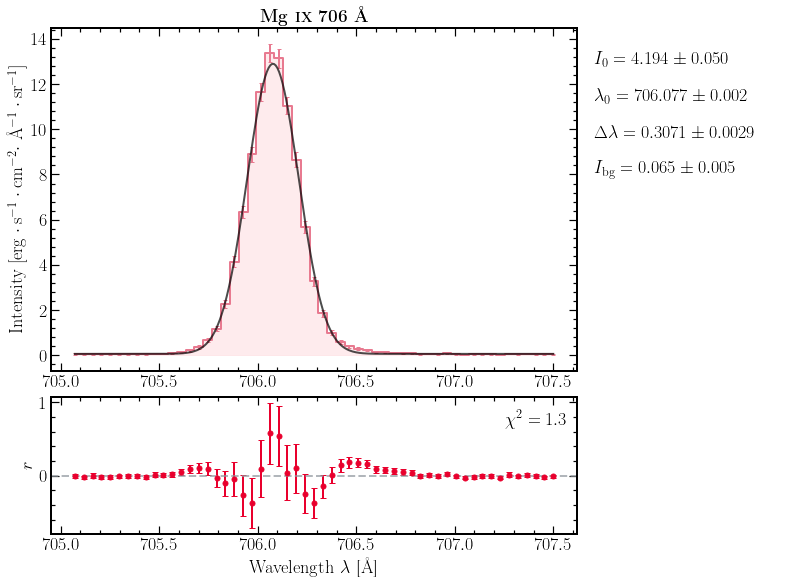

In [44]:
MgIX_706_fit_model = SpectrumFitSingle(data=int_MgIX_706,wvl=wvl_MgIX_706,err=err_MgIX_706,
                                      same_width=True,line_number=1,line_wvl_init=[706.1],
                                      int_max_init=[12],fwhm_init=[0.2])
#MgIX_706_fit_model.plot(plot_fit=False,plot_params=False)
MgIX_706_fit_model.run_lse(absolute_sigma=True)
MgIX_706_fit_model.plot(plot_title=r"\textbf{Mg \textsc{ix} 706 \mbox{\AA}}",plot_hmc=False,
                        xlabel=r"Wavelength $\lambda$ [\mbox{\AA}]",
                        ylabel=r"Intensity $\mathrm{[erg\cdot s^{-1}\cdot cm^{-2}\cdot}$ \mbox{\AA}$\mathrm{^{-1}\cdot sr^{-1}]}$")
print("FWHM after removing instrumental broadening: ",
con_width_funct_4(1,MgIX_706_fit_model.line_wvl_fit,1,MgIX_706_fit_model.fwhm_fit*1000,DET_B=True))

<AxesSubplot:title={'center':'\\textbf{Mg \\textsc{ix} 706 \\mbox{\\AA}}'}, ylabel='Intensity $\\mathrm{[erg\\cdot s^{-1}\\cdot cm^{-2}\\cdot}$ \\mbox{\\AA}$\\mathrm{^{-1}\\cdot sr^{-1}]}$'>

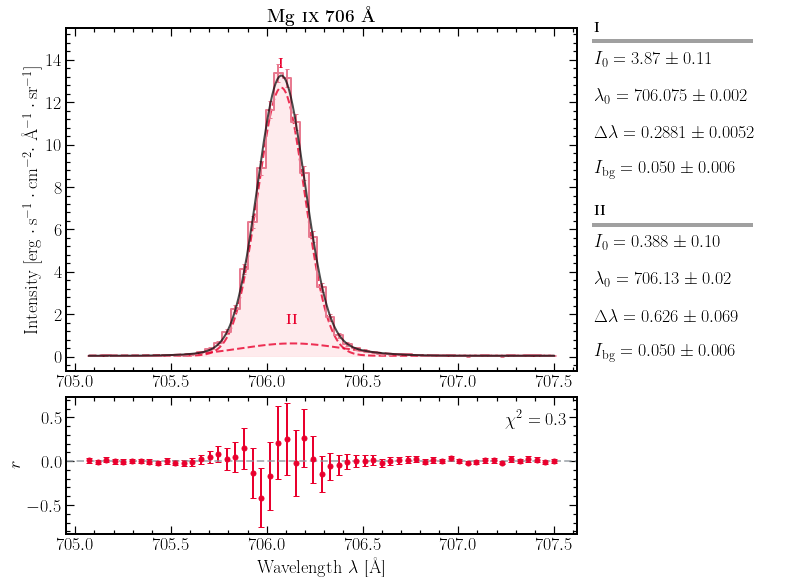

In [45]:
MgIX_706_fit_double_model = SpectrumFitSingle(data=int_MgIX_706,wvl=wvl_MgIX_706,err=err_MgIX_706,
                                      same_width=False,line_number=2,line_wvl_init=[706.1,706.1],
                                      int_max_init=[12,1],fwhm_init=[0.2,0.3])
#MgIX_706_fit_double_model.plot(plot_fit=False,plot_params=False)
MgIX_706_fit_double_model.run_lse(absolute_sigma=True)
MgIX_706_fit_double_model.plot(plot_title=r"\textbf{Mg \textsc{ix} 706 \mbox{\AA}}",plot_hmc=False,
                        xlabel=r"Wavelength $\lambda$ [\mbox{\AA}]",
                        ylabel=r"Intensity $\mathrm{[erg\cdot s^{-1}\cdot cm^{-2}\cdot}$ \mbox{\AA}$\mathrm{^{-1}\cdot sr^{-1}]}$")

/Users/yjzhu/Desktop/Solar/MyPy/juanfit.py:477: UserWarning: Use custom function in the fitting. Will not plot fitted parameters.
  warn("Use custom function in the fitting. Will not plot fitted parameters.")


[7.06078127e+02 3.84039379e+00 2.82738688e-01 5.30380627e+00
 5.57348275e-02]


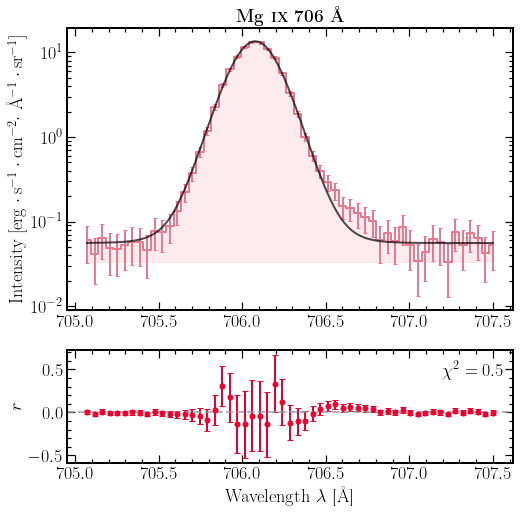

In [46]:
MgIX_706_fit_kappa_model = SpectrumFitCustom(data=int_MgIX_706,wvl=wvl_MgIX_706,err=err_MgIX_706,
                                      custom_func=kappa_func,
                                      custom_init=[706.1,4,0.25,3,0.1])
#NeVIII_770_fit_model.plot(plot_fit=False,plot_params=False)
MgIX_706_fit_kappa_model.run_lse(absolute_sigma=True)
ax = MgIX_706_fit_kappa_model.plot(plot_title=r"\textbf{Mg \textsc{ix} 706 \mbox{\AA}}",plot_hmc=False,
                                 xlabel=r"Wavelength $\lambda$ [\mbox{\AA}]",
                               ylabel=r"Intensity $\mathrm{[erg\cdot s^{-1}\cdot cm^{-2}\cdot}$ \mbox{\AA}$\mathrm{^{-1}\cdot sr^{-1}]}$")
ax.set_yscale("log")
print(MgIX_706_fit_kappa_model.custom_fit)

In [47]:
NaIX_681_slice = (205,250)
wvl_NaIX_681 = wvl_338[NaIX_681_slice[0]:NaIX_681_slice[1]]
radiometry_NaIX_681 = radiometry(1,681.75,1,1,bare=True,kbr=False,photons=False,watts=True,det_a=False,
                                det_b=True,joint=False,separate=True)*1e3

int_NaIX_681 = np.average(sumer_338_window[-30:,NaIX_681_slice[0]:NaIX_681_slice[1]],axis=0)*radiometry_NaIX_681
err_NaIX_681 = np.sqrt(np.sum(300*sumer_338_window[-30:,NaIX_681_slice[0]:NaIX_681_slice[1]],
                        axis=0))/30/300*radiometry_NaIX_681

/Users/yjzhu/Desktop/Solar/MyPy/sumerpy.py:457: UserWarning: No test phase set by default.
  warn("No test phase set by default.")


FWHM after removing instrumental broadening:  [233.67741714]


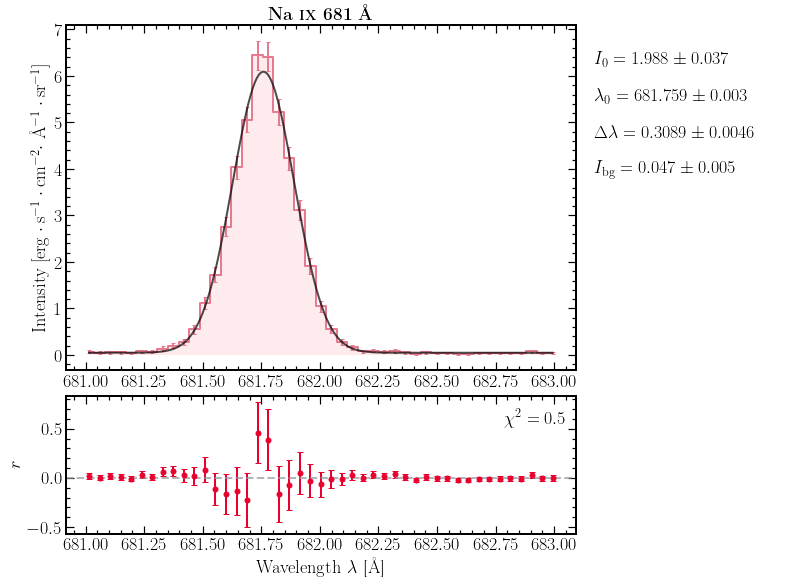

In [48]:
NaIX_681_fit_model = SpectrumFitCustom(data=int_NaIX_681,wvl=wvl_NaIX_681,err=err_NaIX_681,
                                      same_width=True,line_number=1,line_wvl_init=[681.8],
                                      int_max_init=[5],fwhm_init=[0.2])
#NaIX_681_fit_model.plot(plot_fit=False,plot_params=False)
NaIX_681_fit_model.run_lse(absolute_sigma=True)
NaIX_681_fit_model.plot(plot_title=r"\textbf{Na \textsc{ix} 681 \mbox{\AA}}",plot_hmc=False,
                        xlabel=r"Wavelength $\lambda$ [\mbox{\AA}]",
                        ylabel=r"Intensity $\mathrm{[erg\cdot s^{-1}\cdot cm^{-2}\cdot}$ \mbox{\AA}$\mathrm{^{-1}\cdot sr^{-1}]}$")
print("FWHM after removing instrumental broadening: ",
con_width_funct_4(1,NaIX_681_fit_model.line_wvl_fit,1,NaIX_681_fit_model.fwhm_fit*1000,DET_B=True))

<AxesSubplot:title={'center':'\\textbf{Na \\textsc{ix} 681 \\mbox{\\AA}}'}, ylabel='Intensity $\\mathrm{[erg\\cdot s^{-1}\\cdot cm^{-2}\\cdot}$ \\mbox{\\AA}$\\mathrm{^{-1}\\cdot sr^{-1}]}$'>

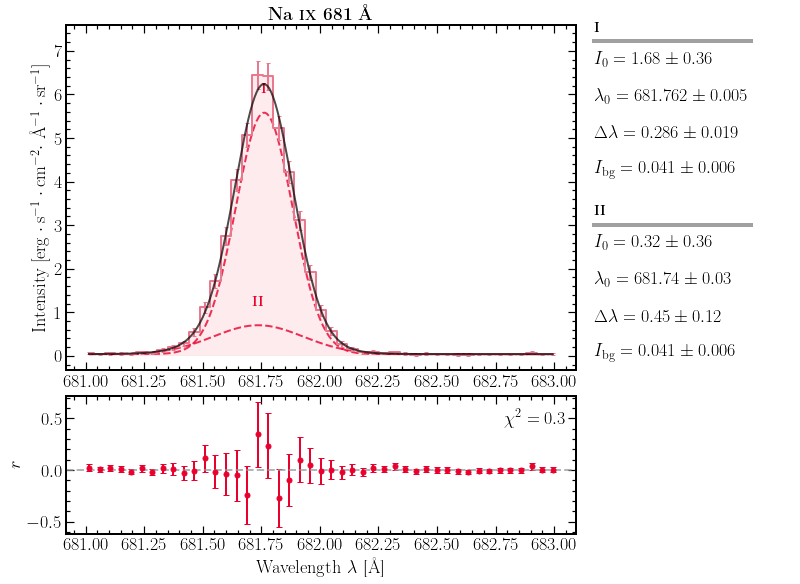

In [49]:
NaIX_681_fit_double_model = SpectrumFitCustom(data=int_NaIX_681,wvl=wvl_NaIX_681,err=err_NaIX_681,
                                      same_width=False,line_number=2,line_wvl_init=[681.8,681.8],
                                      int_max_init=[5,0.5],fwhm_init=[0.3,0.4])
#NaIX_681_fit_model.plot(plot_fit=False,plot_params=False)
NaIX_681_fit_double_model.run_lse(absolute_sigma=True)
NaIX_681_fit_double_model.plot(plot_title=r"\textbf{Na \textsc{ix} 681 \mbox{\AA}}",plot_hmc=False,
                        xlabel=r"Wavelength $\lambda$ [\mbox{\AA}]",
                        ylabel=r"Intensity $\mathrm{[erg\cdot s^{-1}\cdot cm^{-2}\cdot}$ \mbox{\AA}$\mathrm{^{-1}\cdot sr^{-1}]}$")

/Users/yjzhu/Desktop/Solar/MyPy/juanfit.py:477: UserWarning: Use custom function in the fitting. Will not plot fitted parameters.
  warn("Use custom function in the fitting. Will not plot fitted parameters.")


[6.81759214e+02 1.87970277e+00 2.92749806e-01 8.25309313e+00
 4.21467180e-02]


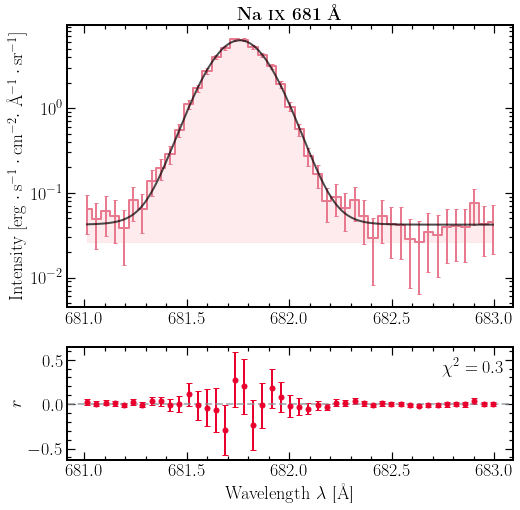

In [50]:
NaIX_681_fit_kappa_model = SpectrumFitCustom(data=int_NaIX_681,wvl=wvl_NaIX_681,err=err_NaIX_681,
                                            custom_func=kappa_func,
                                            custom_init=[681.76,2,0.3,3,0.05])
#NaIX_681_fit_model.plot(plot_fit=False,plot_params=False)
NaIX_681_fit_kappa_model.run_lse(absolute_sigma=True)
ax = NaIX_681_fit_kappa_model.plot(plot_title=r"\textbf{Na \textsc{ix} 681 \mbox{\AA}}",plot_hmc=False,
                        xlabel=r"Wavelength $\lambda$ [\mbox{\AA}]",
                        ylabel=r"Intensity $\mathrm{[erg\cdot s^{-1}\cdot cm^{-2}\cdot}$ \mbox{\AA}$\mathrm{^{-1}\cdot sr^{-1}]}$")
ax.set_yscale("log")
print(NaIX_681_fit_kappa_model.custom_fit)

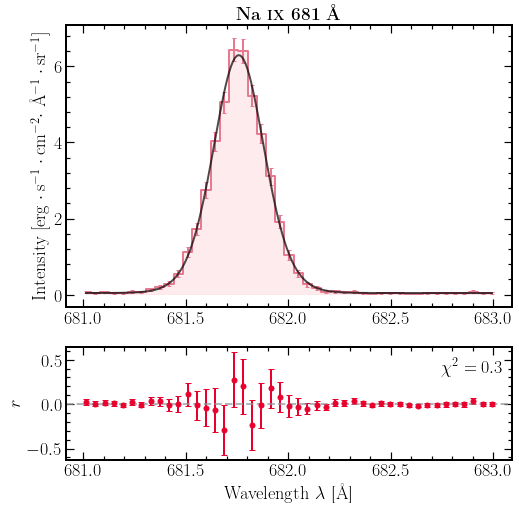

In [51]:
ax = NaIX_681_fit_kappa_model.plot(plot_title=r"\textbf{Na \textsc{ix} 681 \mbox{\AA}}",plot_hmc=False,
                        xlabel=r"Wavelength $\lambda$ [\mbox{\AA}]",
                        ylabel=r"Intensity $\mathrm{[erg\cdot s^{-1}\cdot cm^{-2}\cdot}$ \mbox{\AA}$\mathrm{^{-1}\cdot sr^{-1}]}$")

### Figure 16
<a id='figure16'></a>

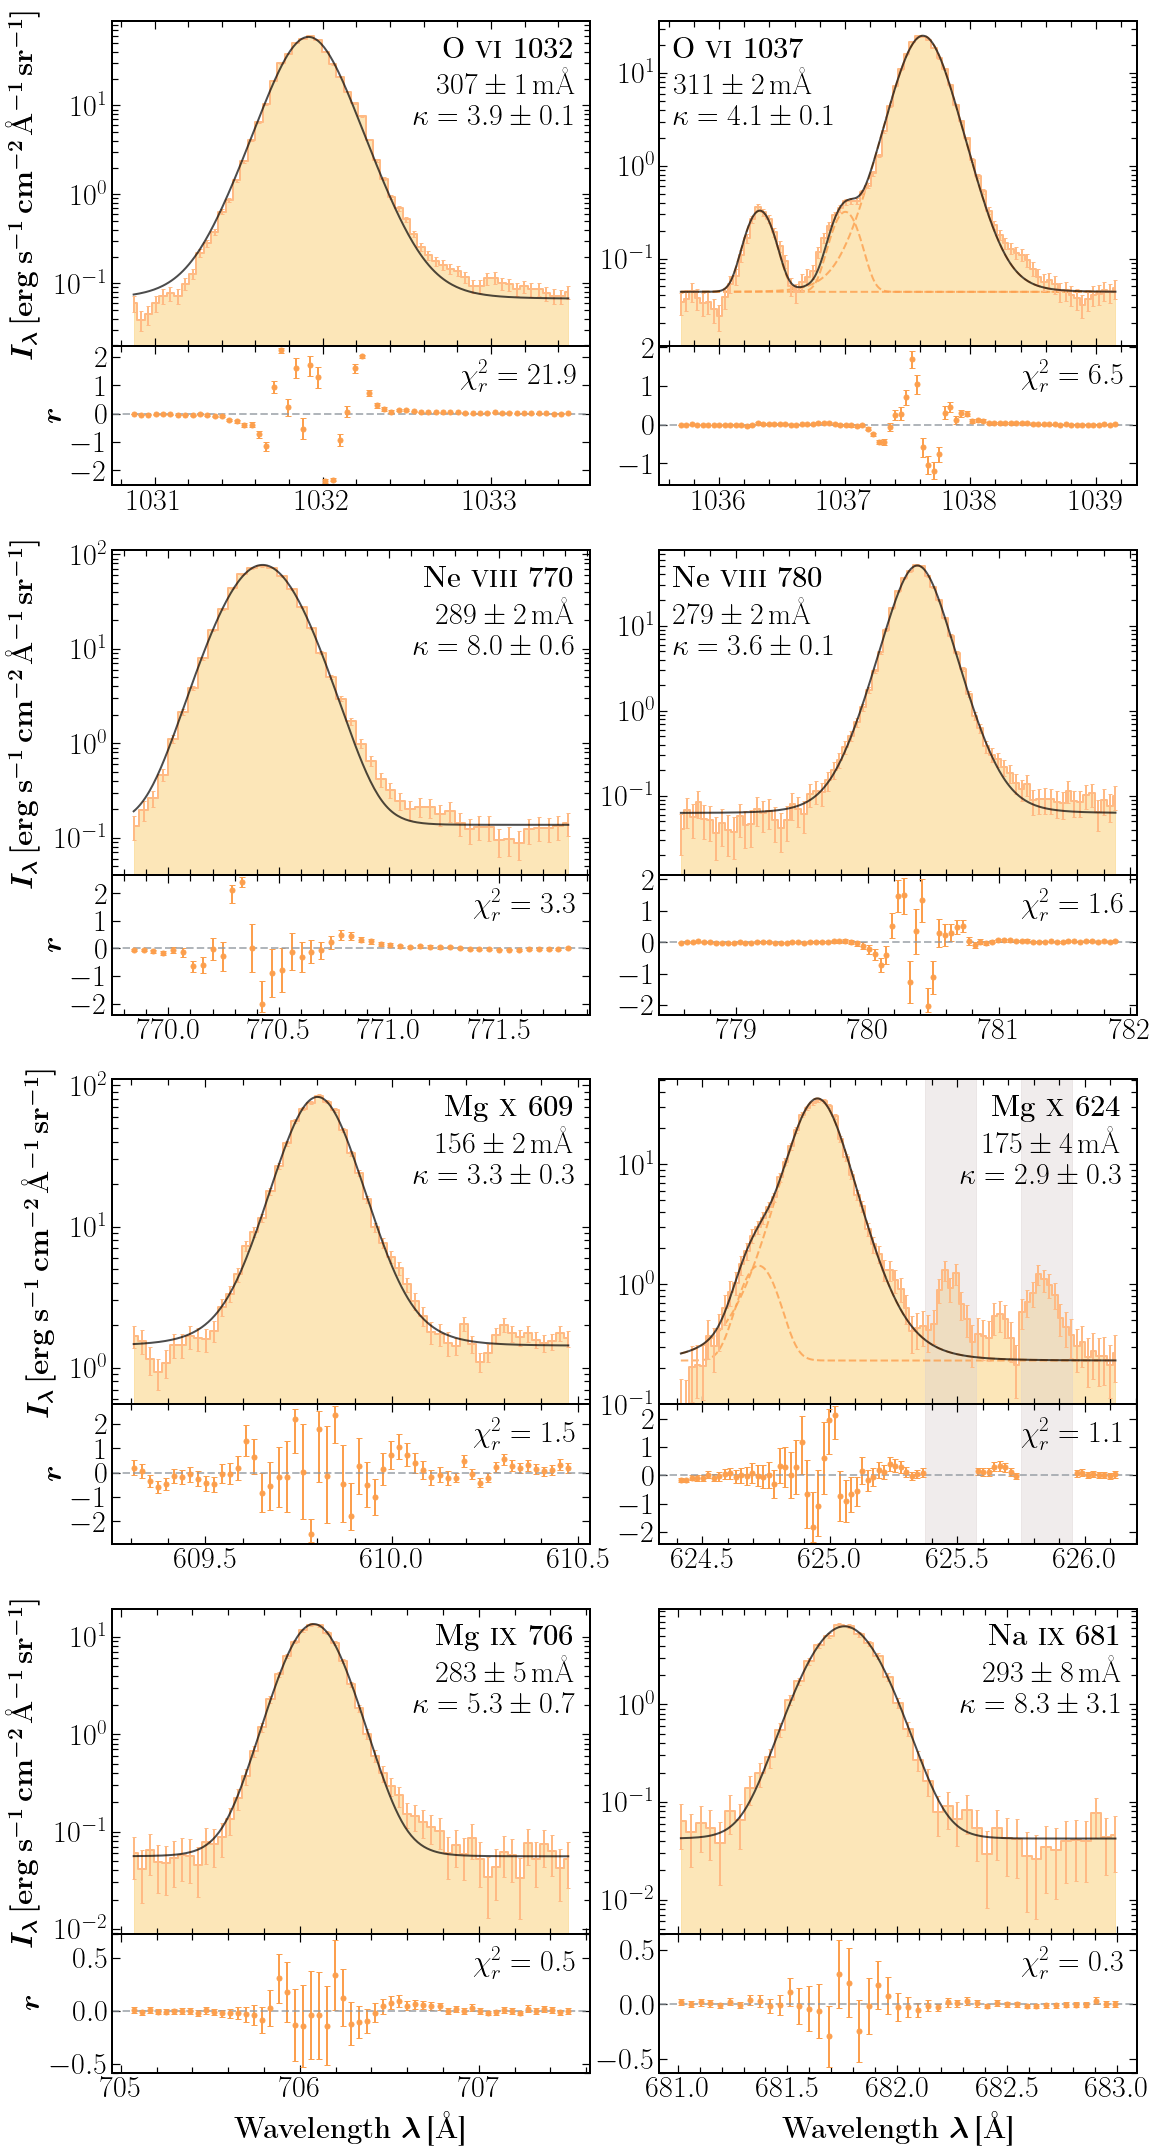

In [52]:

colors_yellow = ["#FFBA84","#FAD689","black","#FC9F4D","#DBD0D0"]
fig = plt.figure(figsize=(16,30),constrained_layout=False)
kappa_fit_models = [OVI_1032_fit_kappa_model, OVI_1037_fit_kappa_model, NeVIII_770_fit_kappa_model, 
                    NeVIII_780_fit_kappa_model, MgX_609_fit_kappa_model,MgX_624_fit_kappa_model,
                    MgIX_706_fit_kappa_model,NaIX_681_fit_kappa_model]
upper_top = 0.99
lower_bottom = 0.04
first_left = 0.1
second_right = 0.99
wspace_gs = 0.06
hspace_gs = 0.03
wlength = (second_right - first_left - wspace_gs)/2
hlength = (upper_top - lower_bottom - 3*hspace_gs)/4

lower_top = lower_bottom + hlength
upper_bottom = upper_top - hlength
first_right = first_left + wlength
second_left = second_right - wlength

text_pos = ["right","left","right","left","right","right","right","right"]
line_names = [r"\textbf{O \textsc{vi} 1032}",r"\textbf{O \textsc{vi} 1037}",
                r"\textbf{Ne \textsc{viii} 770}",r"\textbf{Ne \textsc{viii} 780}",
                r"\textbf{Mg \textsc{x} 609}",r"\textbf{Mg \textsc{x} 624}",
                r"\textbf{Mg \textsc{ix} 706}",r"\textbf{Na \textsc{ix} 681}"]
width_index = [2,6,2,2,2,5,2,2]
for ii, fit_model_ in enumerate(kappa_fit_models):
    gs_left = first_left + (ii%2)*(wlength + wspace_gs)
    gs_right = first_right + (ii%2)*(wlength + wspace_gs)
    gs_top = upper_top - np.floor_divide(ii,2)*(hlength + hspace_gs)
    gs_bottom = upper_bottom - np.floor_divide(ii,2)*(hlength + hspace_gs)

    gs = fig.add_gridspec(nrows=10, ncols=1,left=gs_left, right=gs_right,bottom=gs_bottom,top=gs_top,
                    hspace=0.)
    
    ax_fit = fig.add_subplot(gs[:7,:])
    ax_res = fig.add_subplot(gs[7:,:])

    ln1 = ax_fit.errorbar(fit_model_.wvl,fit_model_.data,yerr = fit_model_.err,
                            ds='steps-mid',color=colors_yellow[0],capsize=2,label = r"$I_{\rm obs}$",lw=2,zorder=15)

    ax_fit.fill_between(fit_model_.wvl,ax_fit.get_ylim()[0],
                        fit_model_.data,step='mid',color=colors_yellow[1],alpha=0.6)

    kappa_fit, kappa_res = fit_model_.get_fit_and_res()
    ln1_fit = ax_fit.plot(fit_model_.wvl_plot,kappa_fit,color=colors_yellow[2],ls="-",label = r"$I_{\rm fit}$",lw=2,
                            zorder=16,alpha=0.7)

    if ii == 1:
        ax_fit.plot(fit_model_.wvl_plot,gaussian(fit_model_.wvl_plot,fit_model_.custom_fit[3],
                    fit_model_.custom_fit[0],fit_model_.custom_fit[5])+fit_model_.custom_fit[-1],
                    lw=2,alpha=0.8,ls="--",color=colors_yellow[3])
        ax_fit.plot(fit_model_.wvl_plot,gaussian(fit_model_.wvl_plot,fit_model_.custom_fit[3]+1037.018-1036.337,
                    fit_model_.custom_fit[1],fit_model_.custom_fit[5])+fit_model_.custom_fit[-1],
                    lw=2,alpha=0.8,ls="--",color=colors_yellow[3])
        ax_fit.plot(fit_model_.wvl_plot,kappa_func(fit_model_.wvl_plot,fit_model_.custom_fit[4],
                    fit_model_.custom_fit[2],fit_model_.custom_fit[6],fit_model_.custom_fit[-2],fit_model_.custom_fit[-1]),
                    lw=2,alpha=0.8,ls="--",color=colors_yellow[3])
    if ii == 5:
        ax_fit.plot(fit_model_.wvl_plot,gaussian(fit_model_.wvl_plot,fit_model_.custom_fit[2],
                    fit_model_.custom_fit[0],fit_model_.custom_fit[4])+fit_model_.custom_fit[-1],
                    lw=2,alpha=0.8,ls="--",color=colors_yellow[3])
        ax_fit.plot(fit_model_.wvl_plot,kappa_func(fit_model_.wvl_plot,fit_model_.custom_fit[3],
                    fit_model_.custom_fit[1],fit_model_.custom_fit[5],fit_model_.custom_fit[-2],fit_model_.custom_fit[-1]),
                    lw=2,alpha=0.8,ls="--",color=colors_yellow[3])

    if text_pos[ii] == "left":
        ax_fit.text(0.03,0.95,line_names[ii],fontsize=fontsize,ha="left",va="top",
                        transform=ax_fit.transAxes)  
        ax_fit.text(0.03,0.85,r"${:.0f}\pm{:.0f}\,\si{{m\angstrom}}$".format(fit_model_.custom_fit[width_index[ii]]*1e3,fit_model_.custom_err[width_index[ii]]*1e3),
                    fontsize=fontsize,ha="left",va="top",transform=ax_fit.transAxes)
        ax_fit.text(0.03,0.75,r"$\kappa = {:.1f}\pm{:.1f}$".format(fit_model_.custom_fit[-2],fit_model_.custom_err[-2]),
                    fontsize=fontsize,ha="left",va="top",transform=ax_fit.transAxes)
    elif text_pos[ii] == "right":
        ax_fit.text(0.97,0.95,line_names[ii],fontsize=fontsize,ha="right",va="top",
                        transform=ax_fit.transAxes)   
        ax_fit.text(0.97,0.85,r"${:.0f}\pm{:.0f}\,\si{{m\angstrom}}$".format(fit_model_.custom_fit[width_index[ii]]*1e3,fit_model_.custom_err[width_index[ii]]*1e3),
                    fontsize=fontsize,ha="right",va="top",transform=ax_fit.transAxes)
        ax_fit.text(0.97,0.75,r"$\kappa = {:.1f}\pm{:.1f}$".format(fit_model_.custom_fit[-2],fit_model_.custom_err[-2]),
                    fontsize=fontsize,ha="right",va="top",transform=ax_fit.transAxes)

    ax_res.errorbar(fit_model_.wvl_tofit,kappa_res,fit_model_.err_tofit,ds='steps-mid',color=colors_yellow[3],capsize=3,
                lw=2,ls="none",marker="o",markersize=5)
    kappa_chi2 = np.sum((kappa_res/fit_model_.err_tofit)**2)/fit_model_.dof
    ax_res.text(0.97,0.9,r"$\chi_r^2 = {:.1f}$".format(kappa_chi2),fontsize=fontsize,
                ha="right",va="top",transform=ax_res.transAxes)

    if fit_model_.mask is not None:
        for mask_ in fit_model_.mask:
            ax_fit.axvspan(mask_[0],mask_[1],color=colors_red[4],alpha=0.4)
            ax_res.axvspan(mask_[0],mask_[1],color=colors_red[4],alpha=0.4)



    ax_res.axhline(0,ls="--",lw=2,color="#91989F",alpha=0.7) 
    

    ax_fit.tick_params(labeltop=False,top=True,bottom=True,labelbottom=False,right=True,
                        direction="in",which="both",labelsize=labelsize)  
    ax_fit.set_yscale("log")
    ax_fit.tick_params(which="major",length=8,width=1.2)
    ax_fit.tick_params(which="minor",length=6,width=1.2)
    ax_fit.xaxis.set_minor_locator(ticker.AutoMinorLocator(5))

    if ii == 5:
        ax_fit.set_ylim(bottom=0.1)

    if ii%2 == 0:
        ax_fit.set_ylabel(r"$\boldsymbol{I_\lambda\,\mathrm{[erg\,s^{-1}\,cm^{-2}}}$\,\textbf{\mbox{\AA}}$\boldsymbol{\mathrm{^{-1}\,sr^{-1}}]}$",
                    fontsize=fontsize,labelpad=15)
        ax_res.set_ylabel(r"$\boldsymbol{r}$",fontsize=fontsize,labelpad=5)

    ax_res.set_yscale("symlog")
    ax_res.tick_params(labeltop=False,top=True,bottom=True,right=True,
                        direction="in",which="both",labelsize=labelsize) 
    ax_res.tick_params(which="major",length=8,width=1.2)
    ax_res.tick_params(which="minor",length=6,width=1.2)
    ax_res.yaxis.set_major_formatter(ticker.ScalarFormatter())
    if ii <= 5:
        ax_res.yaxis.set_major_locator(ticker.FixedLocator((-2,-1,0,1,2)))
    else:
        ax_res.yaxis.set_major_locator(ticker.FixedLocator((-0.5,0,0.5)))

    ax_res.xaxis.set_minor_locator(ticker.AutoMinorLocator(5))

    if ii > 5:
        ax_res.set_xlabel(r"\textbf{Wavelength} $\boldsymbol{\lambda\,}$\textbf{[\mbox{\AA}]}",fontsize=fontsize,labelpad=10)


plt.savefig("../../figs/ms/kappa_fit.pdf",format="pdf",dpi=300)